In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import random
import seaborn as sns
import os
import itertools
import surfplot
import nibabel as nib
import h5py
import scipy.stats as stats
import sklearn.svm as svm
import sklearn
from neuromaps.datasets import fetch_fslr
from statsmodels.stats.multitest import fdrcorrection
from sentence_transformers import SentenceTransformer, util
%matplotlib inline


/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [3]:
# Load parameters + data # data/data/glasser_data_glm_then_concat/glm_betas/sub-03/correct_ses5_task-interdmsctgABBA_run-02.csv
subj = 'sub-03'
runs = ['run-01', 'run-02', 'run-03', 'run-04', 'run-05']

sessions = []
for i in range(1,17):
    sessions = sessions + ['ses%d' % i]


# Get the path of the parent directory
parent_dir = '/Users/xiaoxuan/desktop/Project_task_fMRI/202406_fMRI/data/' # os.path.abspath(os.path.join(cwd, os.pardir))

basedir = parent_dir

# datadir = parent_dir + subj + '/glm_betas/' + subj + "/glm_betas_all_possible_TR_betas_early_late_delay_encoding/" + subj + "/"
datadir = parent_dir + subj + '/glm_betas/' + subj + "/glm_betas_encoding_delay_TR_betas/" + subj + "/" # only include 1 delay and 1 encoding
glasser_atlas_str= basedir + 'Glasser_LR_Dense64k.dlabel.nii'
glasser_atlas = nib.load(glasser_atlas_str).get_fdata()[0].astype(int)
print("Glassier Atlas shape:", glasser_atlas.shape)
num_regions = 360

Glassier Atlas shape: (64984,)


In [4]:
task_betas = {}
df_conditions = {} # 'task-dmsloc_run-01'
# tasks = ['1backloc', '1backctg', '1backobj', 'ctxlco' , 'ctxcol', 
#        'interdmsobjABAB', 'interdmslocABBA', 'interdmslocABAB',
#        'interdmsctgABAB', 'interdmsobjABBA','interdmsctgABBA'] 
tasks = ['1backloc']

for task in tasks:
    task_betas[task] = {}
    df_conditions[task]= {}
                        
    for sess in sessions:
        task_betas[task][sess] = {}
        df_conditions[task][sess] = {}
        for run in runs:
            print(task_betas)
            try:
                # for glm_betas_all_possible_TR_betas_early_late_delay_encoding
                # print(datadir + 'normalizedcorrecttrial_glmmethod1_' + sess + '_' + 'task-' + task + '_' + run + '_betas.h5')
                # h5f = h5py.File(datadir + 'normalizedcorrecttrial_glmmethod1_' + sess + '_' + 'task-' + task + '_' + run + '_betas.h5','r')

                # for glm_betas_encoding_delay_TR_betas, correct trials only, normalized w.r.t dmsloc
                # print(datadir + 'normalized_correct_glmmethod1_' + sess + '_' + 'task-' + task + '_' + run + '_betas.h5')
                # h5f = h5py.File(datadir + 'normalized_correct_glmmethod1_' + sess + '_' + 'task-' + task + '_' + run + '_betas.h5','r')

                # for glm_betas_encoding_delay_TR_betas, correct trials only, non_normalized
                print(datadir + 'correct_glmmethod1_' + sess + '_' + 'task-' + task + '_' + run + '_betas.h5')
                h5f = h5py.File(datadir + 'correct_glmmethod1_' + sess + '_' + 'task-' + task + '_' + run + '_betas.h5','r')
                
                print("correctly open")
                try: 
                    task_betas[task][sess][run] = h5f['betas'][:].copy()
                    # for glm_betas_all_possible_TR_betas_early_late_delay_encoding
                    # df_conditions[task][sess][run] = pd.read_csv(datadir + 'correcttrial_glmmethod1_' + sess + '_' + 'task-' + task + '_' + run + '.csv')

                    # for glm_betas_encoding_delay_TR_betas, correct trials only
                    df_conditions[task][sess][run] = pd.read_csv(datadir + 'correct_glmmethod1_' + sess + '_' + 'task-' + task + '_' + run + '.csv')
                except Exception as e:
                    try:
                        
                        task_betas[task][sess][run] = h5f['betas'][:].copy()
                        df_conditions[task][sess] = {}
                        # for glm_betas_all_possible_TR_betas_early_late_delay_encoding
                        # df_conditions[task][sess][run] = pd.read_csv(datadir + 'correcttrial_glmmethod1_' + sess + '_' + 'task-' + task + '_' + run + '.csv')
    
                        # for glm_betas_encoding_delay_TR_betas, correct trials only
                        df_conditions[task][sess][run] = pd.read_csv(datadir + 'correct_glmmethod1_' + sess + '_' + 'task-' + task + '_' + run + '.csv')

                    except Exception as e:
                        
                        task_betas[task][sess] = {}
                        task_betas[task][sess][run] = h5f['betas'][:].copy()
                        
                        # for glm_betas_all_possible_TR_betas_early_late_delay_encoding
                        # df_conditions[task][sess][run] = pd.read_csv(datadir + 'correcttrial_glmmethod1_' + sess + '_' + 'task-' + task + '_' + run + '.csv')
    
                        # for glm_betas_encoding_delay_TR_betas, correct trials only
                        df_conditions[task][sess][run] = pd.read_csv(datadir + 'correct_glmmethod1_' + sess + '_' + 'task-' + task + '_' + run + '.csv')

                h5f.close()
            except Exception as e:
                print(e)
                continue



{'1backloc': {'ses1': {}}}
/Users/xiaoxuan/desktop/Project_task_fMRI/202406_fMRI/data/sub-03/glm_betas/sub-03/glm_betas_encoding_delay_TR_betas/sub-03/correct_glmmethod1_ses1_task-1backloc_run-01_betas.h5
correctly open
{'1backloc': {'ses1': {'run-01': array([[  404.38263306,  -244.00239071,    91.86177196, ...,
          -85.01521689,  -586.53154837,   -12.95078827],
       [ -623.12245715, -1652.59216064,  2745.21035169, ...,
           85.41228389,  -308.13566044,    27.68474284],
       [  275.80967736,  -379.08661902,  -302.65270286, ...,
          115.32806388,  -190.40927958,   156.38381666],
       ...,
       [   46.30739083, -2289.50448771,  2980.21113326, ...,
          761.36895435,  -105.75721797,   565.28848663],
       [  271.10818714,  -434.76312834,  -276.18861347, ...,
          280.06636325,   -51.13108628,   304.36921869],
       [ -244.09210434,   -69.24905793,   116.82196438, ...,
          910.45057736,  -189.4681873 ,   496.5393725 ]])}}}
/Users/xiaoxuan/desktop

In [5]:
# hierarchical of task_betas/df_conditions: taskname, ses%d, run-0%d
# compare size of df_conditons and task_betas
# todo: 
# glm_betas_all_possible_TR_betas_early_late_delay_encoding: include all trials, both correct and incorrect; 
# the size of the task_betas and df_conditons match to each other
# for correct trials, encoding/delay separation with normalization, that also match

for taskname in task_betas.keys():
    for ses in task_betas[taskname].keys():
        for run in task_betas[taskname][ses].keys():
            assert task_betas[taskname][ses][run].shape[-1] == len(df_conditions[taskname][ses][run])
            # print("shape of task_betas:", task_betas[taskname][ses][run].shape)
            # print("len of df_conditions:", len(df_conditions[taskname][ses][run]))
            # print(df_conditions[taskname][ses][run].head(3))
# print(task_betas.keys())  
# print(task_betas["1backloc"].keys())
# print(task_betas["1backloc"]["ses1"].keys())

In [6]:
# # plot the distribution of maximum and minimum task_betas for each task
# for taskname in task_betas.keys():
#     plt.figure()
#     max_betas = []
#     min_betas = []
#     for ses in task_betas[taskname].keys():
#         for run in task_betas[taskname][ses].keys():
#             max_betas.append(np.max(task_betas[taskname][ses][run].reshape(-1)))
#             min_betas.append(np.min(task_betas[taskname][ses][run].reshape(-1)))
#     print(min_betas)
#     # Plotting the distributions
#     plt.figure(figsize=(4,4))

#     plt.hist(max_betas, bins=30, alpha=0.5, color='blue', label='max_betas')
#     plt.hist(min_betas, bins=30, alpha=0.5, color='orange', label='min_betas')

#     # Adding titles and labels
#     plt.title('Distribution of max_betas and min_betas for %s' % taskname)
#     plt.xlabel('Beta Values')
#     plt.ylabel('Frequency')
#     plt.legend()


In [7]:
# only run this once!
def filter_task_betas(task_betas, df_conditions, phase = "delay", first_delay_only = True):
    # sample betas and df_conditions that match 
    filtered_task_betas = task_betas.copy()
    filtered_task_df = df_conditions.copy()

    for task in task_betas.keys():
        for sess in task_betas[task].keys():
            for run in task_betas[task][sess].keys():
                task_df = df_conditions[task][sess][run]
                betas  = task_betas[task][sess][run] # of shape 65984 *n_trials
                if first_delay_only:
                    filtered_df = task_df[(task_df['prev_stimulus'] == 1000) & (task_df["regressor_type"] == phase)]
                    betas_phase = betas[:, (task_df['prev_stimulus'] == 1000) & (task_df["regressor_type"] == phase)]
                else:
                    filtered_df = task_df[(task_df["regressor_type"] == phase)]
                    betas_phase = betas[:, (task_df["regressor_type"] == phase)]
                    
                filtered_task_betas[task][sess][run] = betas_phase
                filtered_task_df[task][sess][run] = filtered_df

    return filtered_task_betas, filtered_task_df

In [8]:
# check the number of usable trials per run per session per task
n_trials_per_task = {}
ses_indices_per_task = {}
filtered_task_betas, filtered_task_df = filter_task_betas(task_betas, df_conditions, phase = "delay", first_delay_only = True)
for taskname in task_betas.keys():
    n_trials_per_ses = []
    ses_indices_per_task[taskname] = []
    for ses in task_betas[taskname].keys():
        if len(task_betas[taskname][ses].keys()) > 0:
            ses_indices_per_task[taskname].append(ses)
        for run in task_betas[taskname][ses].keys():
            n_trials_per_ses.append(filtered_task_betas[taskname][ses][run].shape[1])
    print("number of trials for task %s per session:" % taskname, n_trials_per_ses)
    print("included session for the given task:", ses_indices_per_task[taskname])
    n_trials_per_task[taskname] = n_trials_per_ses
            

number of trials for task 1backloc per session: [8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
included session for the given task: ['ses1', 'ses2', 'ses3', 'ses4', 'ses7', 'ses8', 'ses9', 'ses10', 'ses13', 'ses14', 'ses15', 'ses16']


In [9]:
# create region mapping
import pandas as pd

map_df_lh = pd.read_excel(basedir + 'Glasser_2016_Table.xlsx')
map_df_lh = map_df_lh.iloc[:,0:2]


# Insert row with region 0
map_df_lh.loc[-1] = [0, 'LG'] # ? region 0 as the white matter/subcortex?
map_df_lh.index = map_df_lh.index + 1  # shifting index
map_df_lh = map_df_lh.sort_index().reset_index(drop=True)

# # Rename columns
map_df_lh.columns = ['region_id', 'region_name']


# # Ensure region_id is numeric
map_df_lh['region_id'] = pd.to_numeric(map_df_lh['region_id'], errors='coerce')

# # Copy the left hemisphere DataFrame for the right hemisphere
map_df_rh = map_df_lh.copy()

# # Increase map_df_rh region_id by 180 and index by 180
map_df_rh['region_id'] = map_df_rh['region_id'] + 180
map_df_rh.index = map_df_rh.index + 180

# # Concatenate both hemispheres
map_df = pd.concat([map_df_lh, map_df_rh], axis=0).reset_index(drop=True)

mapped_atlas = {}

for id, name in zip(map_df['region_id'], map_df['region_name']):
    # indexes of id in glasser_atlas
    if str(name) not in mapped_atlas.keys():
        mapped_atlas[str(name)] = np.where(glasser_atlas == id)[0]
    else:
        mapped_atlas[str(name)] = np.concatenate((mapped_atlas[str(name)], np.where(glasser_atlas == id)[0]))


In [10]:
mapped_atlas.keys() # all possible the Area/nName here?

dict_keys(['LG', 'Area\nName', 'V1', 'MST', 'V6', 'V2', 'V3', 'V4', 'V8', '4', '3b', 'FEF', 'PEF', '55b', 'V3A', 'RSC', 'POS2', 'V7', 'IPS1', 'FFC', 'V3B', 'LO1', 'LO2', 'PIT', 'MT', 'A1', 'PSL', 'SFL', 'PCV', 'STV', '7Pm', '7m', 'POS1', '23d', 'v23ab', 'd23ab', '31pv', '5m', '5mv', '23c', '5L', '24dd', '24dv', '7AL', 'SCEF', '6ma', '7Am', '7Pl', '7PC', 'LIPv', 'VIP', 'MIP', '1', '2', '3a', '6d', '6mp', '6v', 'p24pr', '33pr', 'a24pr', 'p32pr', 'a24', 'd32', '8BM', 'p32', '10r', '47m', '8Av', '8Ad', '9m', '8BL', '9p', '10d', '8C', '44', '45', '47l', 'a47r', '6r', 'IFJa', 'IFJp', 'IFSp', 'IFSa', 'p9-\n46v', '46', 'a9-\n46v', '9-46d', '9a', '10v', 'a10p', '10pp', '11l', '13l', 'OFC', '47s', 'LIPd', '6a', 'i6-8', 's6-8', '43', 'OP4', 'OP1', 'OP2-3', '52', 'RI', 'PFcm', 'PoI2', 'TA2', 'FOP4', 'MI', 'Pir', 'AVI', 'AAIC', 'FOP1', 'FOP3', 'FOP2', 'PFt', 'AIP', 'EC', 'PreS', 'H', 'ProS', 'PeEc', 'STGa', 'PBelt', 'A5', 'PHA1', 'PHA3', 'STSda', 'STSdp', 'STSvp', 'TGd', 'TE1a', 'TE1p', 'TE2a', 'TF

In [12]:
# Delete regions outside the loop to avoid modifying the dictionary during iteration
for region in set(regions_to_delete):
    del mapped_atlas[region]


In [13]:
# sample data from a given brain region
def regionwise_beta(task_betas, mapped_atlas, region = "V1"):

    if region == "whole_brain":
        return task_betas
        
    regionwise_task_betas = {}

    for task in task_betas.keys():
        regionwise_task_betas[task] = {}
        for sess in task_betas[task].keys():
            regionwise_task_betas[task][sess] = {}
            for run in task_betas[task][sess].keys():
                
                region_idx = mapped_atlas[region]
                betas  = task_betas[task][sess][run][region_idx,:]

                regionwise_task_betas[task][sess][run] = betas
    return regionwise_task_betas


In [14]:
# Subsample regions that have data
regions_to_delete = []

for region in mapped_atlas.keys():
    regionwise_task_betas = regionwise_beta(filtered_task_betas, mapped_atlas, region=region)
    for task in regionwise_task_betas.keys():
        for ses in regionwise_task_betas[task].keys():
            if len(regionwise_task_betas[task][ses]) == 0:
                continue
            for run in regionwise_task_betas[task][ses].keys():
                if regionwise_task_betas[task][ses][run].shape[0] == 0:
                    regions_to_delete.append(region)
                    break  # Exit loop to avoid further processing for this region



## sanity check 0: beta normalization [mean and variance]
for each voxel/brain region, calculate the mean and variance of the beta within each run, and plot how it changes across sessions

(64984, 8)
(64984, 9)
(64984, 9)
(64984, 9)
(64984, 9)
(64984, 9)
(64984, 9)
(64984, 9)
(64984, 9)
(64984, 9)
(64984, 9)
(64984, 9)


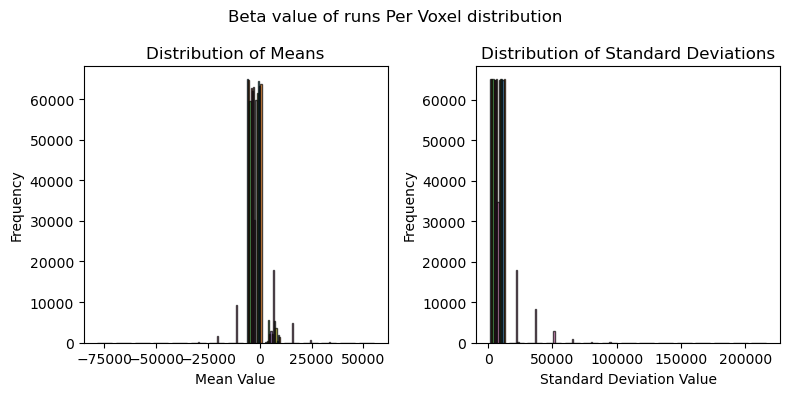

In [20]:
# analysis at voxel level
means = []
stds = []
for task in filtered_task_betas.keys():
    for ses in filtered_task_betas[task].keys():
        if len(filtered_task_betas[task][ses]) == 0:
            continue
        for run in filtered_task_betas[task][ses].keys():
            print(filtered_task_betas[task][ses][run].shape)
            means.append(np.mean(filtered_task_betas[task][ses][run], axis = -1))
            stds.append(np.std(filtered_task_betas[task][ses][run], axis = -1))
            
# Plotting the distribution of means
plt.figure(figsize=(8, 4))

# Mean distribution plot
plt.subplot(1, 2, 1)
plt.hist(means, bins=15, alpha=0.7, edgecolor='black')
plt.title('Distribution of Means')
plt.xlabel('Mean Value')
plt.ylabel('Frequency')

# Standard deviation distribution plot
plt.subplot(1, 2, 2)
plt.hist(stds, bins=15, alpha=0.7, edgecolor='black')
plt.title('Distribution of Standard Deviations')
plt.xlabel('Standard Deviation Value')
plt.ylabel('Frequency')

plt.suptitle("Beta value of runs Per Voxel distribution")

plt.tight_layout()
plt.show()

/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/xiaoxuan/anaconda3/envs/takumri/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


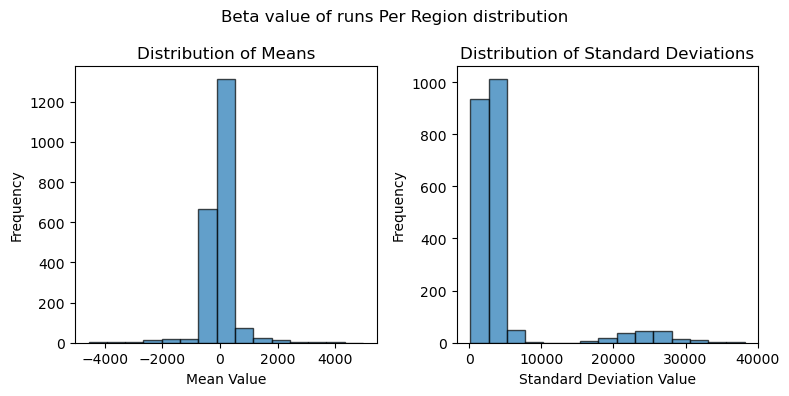

In [23]:
# analysis at region level
means = []
stds = []
for region in mapped_atlas.keys():
    regionwise_task_betas = regionwise_beta(filtered_task_betas, mapped_atlas, region=region)
    
    for task in regionwise_task_betas.keys():
        for ses in regionwise_task_betas[task].keys():
            if len(regionwise_task_betas[task][ses]) == 0:
                continue
            for run in regionwise_task_betas[task][ses].keys():
                means.append(np.mean(regionwise_task_betas[task][ses][run]))
                stds.append(np.std(regionwise_task_betas[task][ses][run]))
            
# Plotting the distribution of means
plt.figure(figsize=(8, 4))

# Mean distribution plot
plt.subplot(1, 2, 1)
plt.hist(means, bins=15, alpha=0.7, edgecolor='black')
plt.title('Distribution of Means')
plt.xlabel('Mean Value')
plt.ylabel('Frequency')

# Standard deviation distribution plot
plt.subplot(1, 2, 2)
plt.hist(stds, bins=15, alpha=0.7, edgecolor='black')
plt.title('Distribution of Standard Deviations')
plt.xlabel('Standard Deviation Value')
plt.ylabel('Frequency')

plt.suptitle("Beta value of runs Per Region distribution")

plt.tight_layout()
plt.show()

## sanity check 1: for whole-brain/V1, for single task, calculate RSM subset of sessions by complementary subset of sessions (except for 1back ctg and 1back obj that only has data from two sessions)

In [100]:
# Function to calculate cosine similarity between two vectors
def cosine_similarity_vector(a, b):
    # use sentence_transformer definition of cosine similarity
    # cosine_similarity = util.cos_sim(a, b)

    # naive definition of cosine similarity
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    
    cosine_similarity = np.dot(a, b) / (norm_a * norm_b)
    return cosine_similarity

# Function to calculate Pearson correlation between two vectors
def pearson_correlation_vector(a, b):
    mean_a = np.mean(a)
    mean_b = np.mean(b)
    
    # Subtract the mean from each vector
    a_centered = a - mean_a
    b_centered = b - mean_b
    
    # Calculate Pearson correlation coefficient
    correlation = np.dot(a_centered, b_centered) / (np.linalg.norm(a_centered) * np.linalg.norm(b_centered))
    
    return correlation



# def within_task_sessionwise_cosine_similarity(task_betas,  method = "cosine", n_bootstraps = 10):
#     # input: data: list of numpy arrays, bootstrapped data from each session that contains the given task
#     # for each task (except for 1back ctg and 1back obj), for all sessions, randomly split all sessions into half, then bootstrap over trials
#     # calculate sessions-sessions RSA matrix

#     # reorganize task_betas
#     data = {}
    
#     # Session counter for renumbering
#     session_counter = 0
    
#     # Iterate through the original dictionary
#     for session, runs in task_betas.items():
        
#         if len(runs) >= 1:
#             # Concatenate all runs together
#             concatenated_data = []
#             for run_data in runs.values():
#                 concatenated_data.append(run_data.T)
#             # Add the concatenated data to the new dictionary with a continuous session number
#             data[f"ses-{session_counter}"] = np.concatenate(concatenated_data, axis = 0)
            
#             session_counter += 1
#     n_session = session_counter

#     # split half session all combination numbers
#     n_half_sessions = n_session // 2
#     # Generate all possible combinations of half of the session numbers
#     combinations = list(itertools.combinations(list(range(0, n_session)), n_half_sessions))

#     # Initialize matrices to store RSM values and standard deviations
#     rsm_matrix = np.zeros((len(combinations), 1))
#     rsm_std_matrix = np.zeros((len(combinations), 1))

#     # Calculate RSM for each pair of elements
#     for i in range(len(combinations)):
#         session_indices_a = combinations[i]
#         session_indices_b = list(set(list(range(0, n_session))) - set(session_indices_a))
        
#         rsm_values = []
#         for _ in range(n_bootstraps):
#             # Randomly sample trials and average for data from the first half of the session
#             concatenated_data = []
#             for session_number in session_indices_a:
#                 concatenated_data.append(data[f"ses-{session_number}"])
#             concatenated_data = np.concatenate(concatenated_data, axis = 0)

#             # Randomly sample 80% of the trials
#             sample_size = int(0.8 * len(concatenated_data))
#             sampled_indices_a = random.sample(range(concatenated_data.shape[0]), sample_size)
#             sampled_data_a = concatenated_data[sampled_indices_a]

#             # Randomly sample trials and average for data from the first half of the session
#             concatenated_data = []
#             for session_number in session_indices_b:
#                 concatenated_data.append(data[f"ses-{session_number}"])
#             concatenated_data = np.concatenate(concatenated_data, axis = 0)

#             # Randomly sample 80% of the trials
#             sample_size = int(0.8 * len(concatenated_data))
#             sampled_indices_b = random.sample(range(concatenated_data.shape[0]), sample_size)
#             sampled_data_b = concatenated_data[sampled_indices_b]

            
#             mean_sampled_data_a = np.mean(sampled_data_a, axis = 0)
#             mean_sampled_data_b = np.mean(sampled_data_b, axis = 0)
            
              
#             if method == "cosine":
#                 # Compute RSM (cosine similarity in this case)
#                 rsm_value = cosine_similarity_vector(mean_sampled_data_a, mean_sampled_data_b)
#             elif method == "pearson":
#                 rsm_value = pearson_correlation_vector(mean_sampled_data_a, mean_sampled_data_b)
#             rsm_values.append(rsm_value)
            
#         # Store the mean RSM value and its standard deviation
#         rsm_matrix[i, 0] = np.mean(rsm_values)
#         rsm_std_matrix[i, 0] = np.std(rsm_values)
#     print("number of trials:", sampled_data_b.shape[0])
#     return rsm_matrix, rsm_std_matrix
    


In [18]:
print(n_trials_per_task)

{'1backloc': [8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], '1backctg': [9, 9], '1backobj': [9, 5], 'ctxlco': [11, 17, 16, 18, 20, 14, 16, 19, 16, 18, 17, 18, 16, 17, 19, 16], 'ctxcol': [11, 18, 13, 15, 13, 15, 9, 14, 12, 13, 18, 17, 14, 13, 17, 16], 'interdmsobjABAB': [10, 16, 16, 15, 16], 'interdmslocABBA': [16, 15, 9, 16, 16, 16, 15, 16, 16, 16, 16, 8, 16, 16], 'interdmslocABAB': [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16], 'interdmsctgABAB': [16, 16, 16, 10, 16], 'interdmsobjABBA': [16, 15, 16, 16, 16], 'interdmsctgABBA': [8, 10, 16, 16, 16]}


number of trials: 42


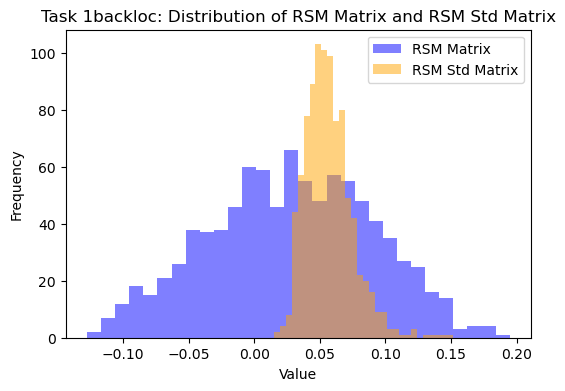

number of trials: 117


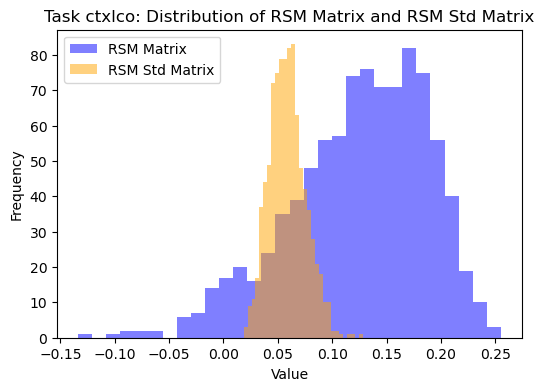

number of trials: 96


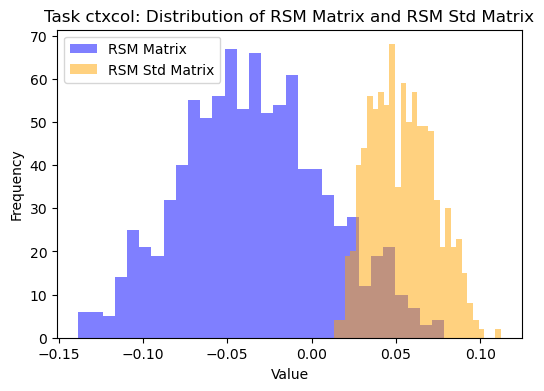

number of trials: 33


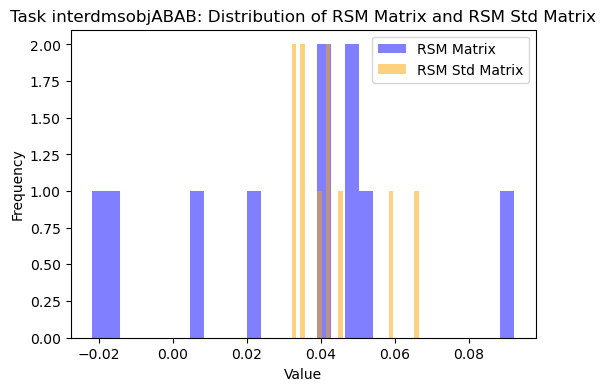

number of trials: 70


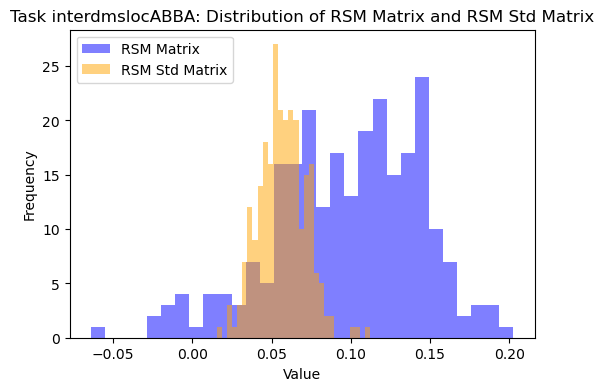

number of trials: 89


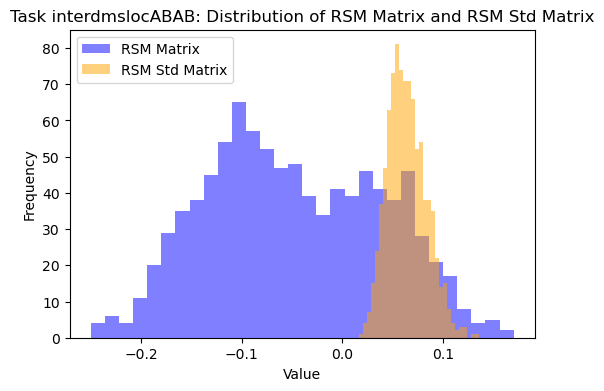

number of trials: 38


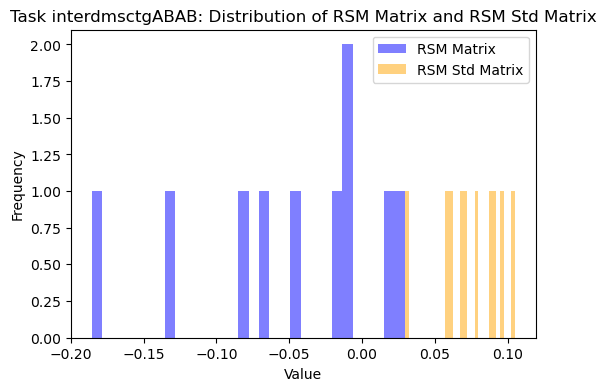

number of trials: 24


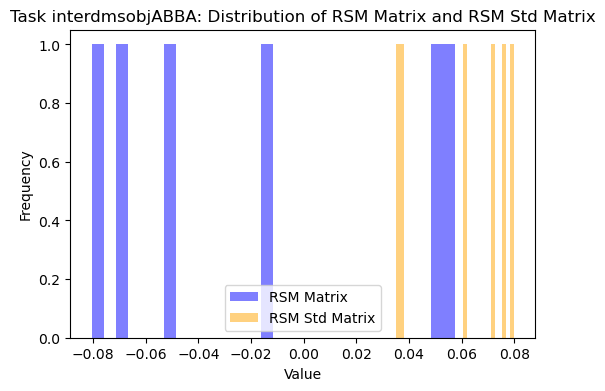

number of trials: 27


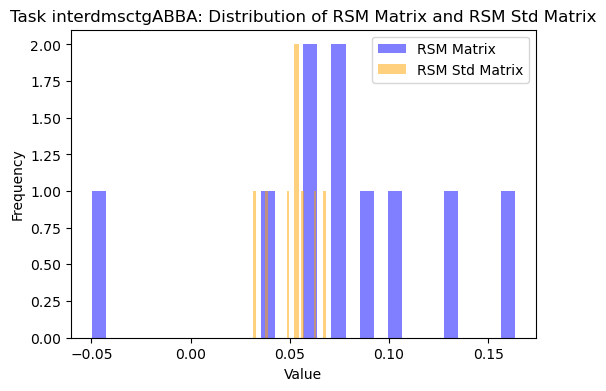

In [112]:
import matplotlib.pyplot as plt
region = "V1"
metric = "cosine"
regionwise_task_betas = regionwise_beta(filtered_task_betas,  mapped_atlas, region = region)
# Number of bootstraps
n_bootstraps = 10

for task in regionwise_task_betas.keys():
    if task == "1backctg" or task == "1backobj": continue
    curr_task_betas = regionwise_task_betas[task]
    rsm_matrix, rsm_std_matrix = within_task_sessionwise_cosine_similarity(curr_task_betas, method = metric, n_bootstraps = n_bootstraps)

    rsm_matrix = rsm_matrix.reshape(-1)
    rsm_std_matrix = rsm_std_matrix.reshape(-1)
    
    # Plotting the distributions
    plt.figure(figsize=(6, 4))
    
    # Plot the distribution of rsm_matrix
    plt.hist(rsm_matrix, bins=30, alpha=0.5, label='RSM Matrix', color='blue')
    
    # Plot the distribution of rsm_std_matrix
    plt.hist(rsm_std_matrix, bins=30, alpha=0.5, label='RSM Std Matrix', color='orange')
    
    # Adding title and labels
    plt.title('Task %s: Distribution of RSM Matrix and RSM Std Matrix' % task)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    # Adding a legend
    plt.legend()
    
    # Show the plot
    plt.show()
    


In [101]:
# for randomly sampled half sessions, calculate taskwise RSM matrix

import re
def within_half_sessions_taskwise_cosine_similarity(task_betas,  method = "cosine", selected_session_indices = None ):
    # input: task_betas: dictionary of data containing for each task, each session, each run of the beta value
    # for each task (except for 1back ctg and 1back obj), for all sessions, randomly sample half of the sessions
    # calculate task-wise RSA matrix

    # reorganize task_betas
    data = []

    if selected_session_indices is None:
        for task in task_betas.keys():
            n_session = len(task_betas[task].keys())
            break
        # split half session all combination numbers
        n_selected_session = 12
        # Generate all possible combinations of half of the session numbers
        combinations = list(itertools.combinations(list(range(1, n_session+1)), n_selected_session))
        # sample half of the session index
        selected_combo_index = random.randint(0, len(combinations))
        selected_session_indices = combinations[selected_combo_index]

    print(selected_session_indices)    
    # Iterate through the original dictionary
    for task in task_betas.keys():
        
        if task == "1backctg" or task == "1backobj": continue
        concatenated_data = []
        for session in task_betas[task].keys():
            # Use regular expression to extract the integer part
            match = re.search(r'ses(\d+)', session)
            curr_index = int(match.group(1))  # Extracts and converts to integer
            
            if curr_index not in selected_session_indices:
                continue
            
            if len(task_betas[task][session].keys()) > 0:
                for _, run_data in task_betas[task][session].items():    
                    concatenated_data.append(run_data.T)
        # Add the concatenated data to the new dictionary with a continuous session number
        if len(concatenated_data) == 0: 
            print(f"{task}")
        data.append(np.concatenate(concatenated_data, axis = 0))
    
    # Initialize matrices to store RSM
    rsm_matrix = np.zeros((len(data), len(data)))
   

    # Calculate RSM for each pair of tasks
    for i in range(len(data)):
        for j in range(len(data)):
            vector_a  = np.mean(data[i], axis = 0)
            vector_b = np.mean(data[j], axis = 0)
            if method == "cosine":
                # Compute RSM (cosine similarity in this case)
                rsm_matrix[i,j] = cosine_similarity_vector(vector_a, vector_b)
        
    
    return rsm_matrix, selected_session_indices
    


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[1 2 3 4 5 6 7]


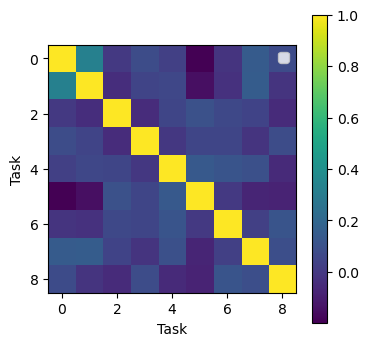

In [102]:
import matplotlib.pyplot as plt
region = "V1"
metric = "cosine"
regionwise_task_betas = regionwise_beta(filtered_task_betas,  mapped_atlas, region = region)
# nbootstraps = 100

# rsm_matrices = []
# subsampled_session_indices = []
# for i in range(nbootstraps):
#     random.seed(i)
#     rsm_matrix, selected_session_indices = within_half_sessions_taskwise_cosine_similarity(regionwise_task_betas,  method = metric )
#     rsm_matrices.append(rsm_matrix[np.triu_indices(rsm_matrix.shape[0], k=1)].reshape(-1))
#     subsampled_session_indices.append(selected_session_indices)
    
selected_session_indices = np.arange(1,8)    
rsm_matrix, selected_session_indices = within_half_sessions_taskwise_cosine_similarity(regionwise_task_betas,  method = metric, selected_session_indices = selected_session_indices )

# Plotting the heatmap
plt.figure(figsize=(4, 4))

# Plot the distribution of rsm_matrix
# plt.hist(rsm_matrix, bins=30, alpha=0.5, label='RSM Matrix', color='blue')
plt.imshow(rsm_matrix)
plt.colorbar()


# Adding title and labels
# plt.title('Task %s: Distribution of RSM Matrix and RSM Std Matrix' % task)
plt.xlabel('Task')
plt.ylabel('Task')

# Adding a legend
plt.legend()

# Show the plot
plt.show()
    


In [80]:
corrs = []
overlap_session_indices = []
for i in range(len(rsm_matrices)-1):
    for j in range(i+1, len(rsm_matrices)):
        corrs.append(pearson_correlation_vector(rsm_matrices[i], rsm_matrices[j]))
        if corrs[-1] > 0.7:
            overlap_session_indices.append(len(list(set(subsampled_session_indices[i]) & set(subsampled_session_indices[j]))))

Text(0.5, 1.0, 'number of overlapped session required to ensure correlation between RSMs are higher than 0.7')

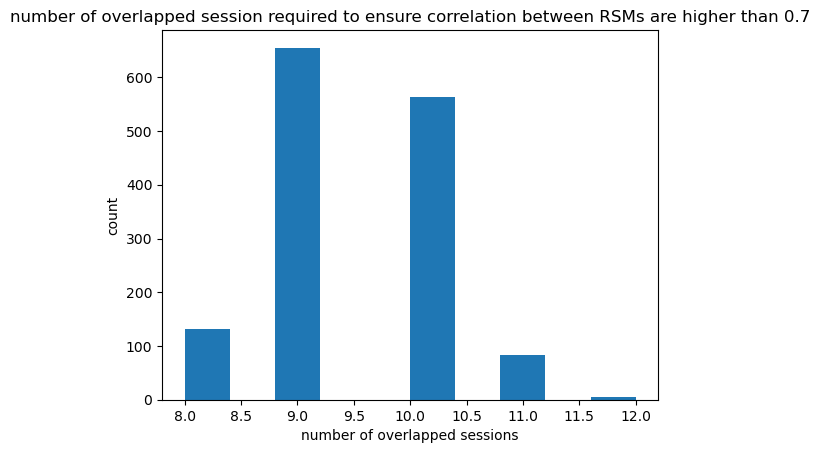

In [82]:
plt.hist(overlap_session_indices)
plt.xlabel("number of overlapped sessions")
plt.ylabel("count")
plt.title("number of overlapped session required to ensure correlation between RSMs are higher than 0.7")

Text(0.5, 1.0, 'correlation between task-wise RSM by subsample a subset of session')

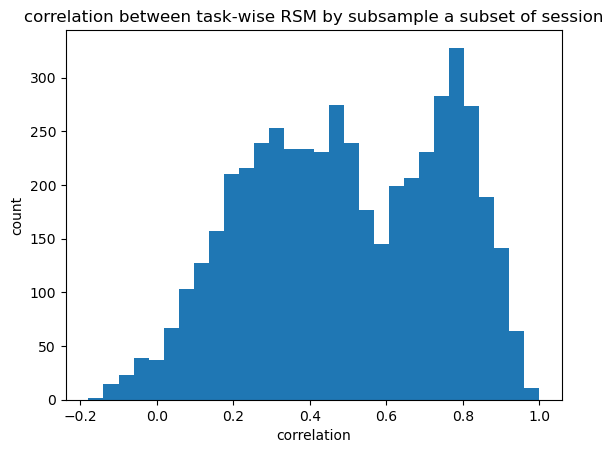

In [79]:
# plot the histogram of the correlations
plt.hist(corrs, bins = 30)
plt.xlabel("correlation")
plt.ylabel("count")
plt.title("correlation between task-wise RSM by subsample a subset of session")

In [91]:
# if there are more than 8 overlapped sessions, will the corrs smaller than 0.7? if so, what are the different sessions?
subsampled_corrs = []
overlap_session_indices = []
for i in range(len(rsm_matrices)-1):
    for j in range(i+1, len(rsm_matrices)):
        if len(list(set(subsampled_session_indices[i]) & set(subsampled_session_indices[j]))) >= 10:
            if pearson_correlation_vector(rsm_matrices[i], rsm_matrices[j]) <= 0.5:
                subsampled_corrs.append(pearson_correlation_vector(rsm_matrices[i], rsm_matrices[j]))
                overlap_session_indices.append(list(set(subsampled_session_indices[i]) - set(subsampled_session_indices[j])))

In [92]:
unique_values = list(set(val for sublist in subsampled_session_indices for val in sublist))
print(unique_values)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


In [75]:
common_values = set(overlap_session_indices[0]).intersection(*overlap_session_indices[1:])

# Convert the result back to a list if needed
common_values = list(common_values)

print(common_values)

[]


In [ ]:
# identify the split that give maximum session-wise similarity value and take a look at the std

In [113]:
# baseline check: 
# for whole-brain/V1, for single task, 
# calculate RSM subset of sessions, subset of trials, by the complementary of the trials
# (except for 1back ctg and 1back obj that only has data from two sessions)


def within_task_within_subset_sessionwise_cosine_similarity(task_betas,  method = "cosine", n_bootstraps = 10):
    # input: data: list of numpy arrays, bootstrapped data from each session that contains the given task
    # for each task (except for 1back ctg and 1back obj), for randomly selected subset of  sessions
    # randomly split all trials into half, and the complementary to the half of the sessions
    # calculate trials-trials RSA matrix

    # reorganize task_betas
    data = {}
    
    # Session counter for renumbering
    session_counter = 0
    
    # Iterate through the original dictionary
    for session, runs in task_betas.items():
        
        if len(runs) >= 1:
            # Concatenate all runs together
            concatenated_data = []
            for run_data in runs.values():
                concatenated_data.append(run_data.T)
            # Add the concatenated data to the new dictionary with a continuous session number
            data[f"ses-{session_counter}"] = np.concatenate(concatenated_data, axis = 0)
            
            session_counter += 1
    n_session = session_counter

    # split half session all combination numbers
    n_half_sessions = n_session // 2
    # Generate all possible combinations of half of the session numbers
    combinations = list(itertools.combinations(list(range(0, n_session)), n_half_sessions))

    # Initialize matrices to store RSM values and standard deviations
    rsm_matrix = np.zeros((len(combinations), 1))
    rsm_std_matrix = np.zeros((len(combinations), 1))

    # Calculate RSM for each pair of elements
    for i in range(len(combinations)):
        session_indices = combinations[i]
        
        rsm_values = []
        for _ in range(n_bootstraps):
            # Randomly sample trials and average for data from the first half of the session
            concatenated_data = []
            for session_number in session_indices:
                concatenated_data.append(data[f"ses-{session_number}"])
            concatenated_data = np.concatenate(concatenated_data, axis = 0)

            # Randomly sample 50% of the trials
            sample_size = int(0.5 * len(concatenated_data))
            sampled_indices_a = random.sample(range(concatenated_data.shape[0]), sample_size)
            sampled_data_a = concatenated_data[sampled_indices_a]

            # get the rest of the 50% of the trials
            sampled_indices_b = list(set(range(concatenated_data.shape[0])) - set(sampled_indices_a))
            sampled_data_b = concatenated_data[sampled_indices_b]

            #  # alternatively: Randomly sample another 50% of the trials => statistically not valid
            # sample_size = int(0.5 * len(concatenated_data))
            # sampled_indices_b = random.sample(range(concatenated_data.shape[0]), sample_size)
            # sampled_data_b = concatenated_data[sampled_indices_b]

            # sanity check: size of the data
            # print("shape of the sampled data:", sampled_data_b.shape)
            
            mean_sampled_data_a = np.mean(sampled_data_a, axis = 0)
            mean_sampled_data_b = np.mean(sampled_data_b, axis = 0)
            
              
            if method == "cosine":
                # Compute RSM (cosine similarity in this case)
                rsm_value = cosine_similarity_vector(mean_sampled_data_a, mean_sampled_data_b)
            elif method == "pearson":
                rsm_value = pearson_correlation_vector(mean_sampled_data_a, mean_sampled_data_b)
            rsm_values.append(rsm_value)
            
        # Store the mean RSM value and its standard deviation
        rsm_matrix[i, 0] = np.mean(rsm_values)
        rsm_std_matrix[i, 0] = np.std(rsm_values)
    print("number of trials:", sampled_data_b.shape[0])
    return rsm_matrix, rsm_std_matrix
    



number of trials: 27


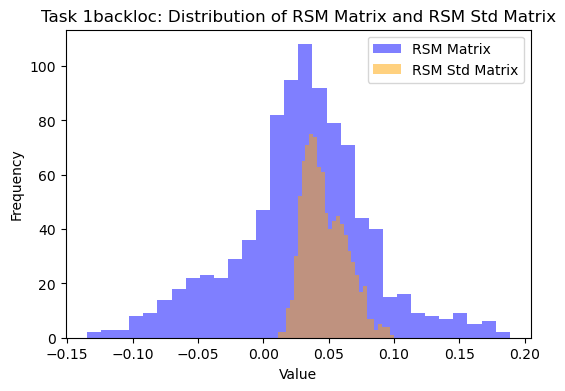

number of trials: 61


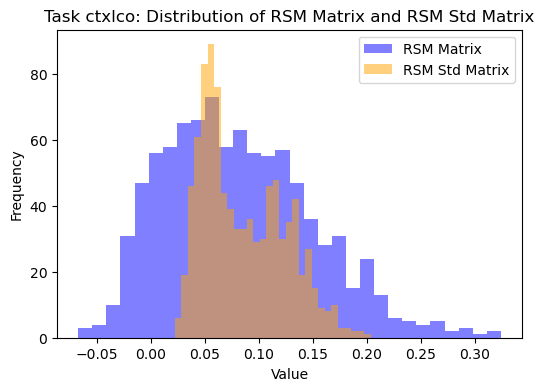

number of trials: 54


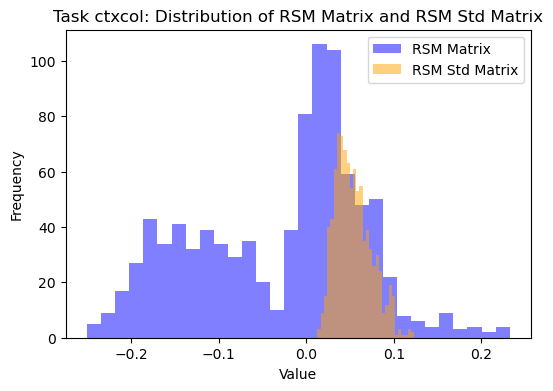

number of trials: 16


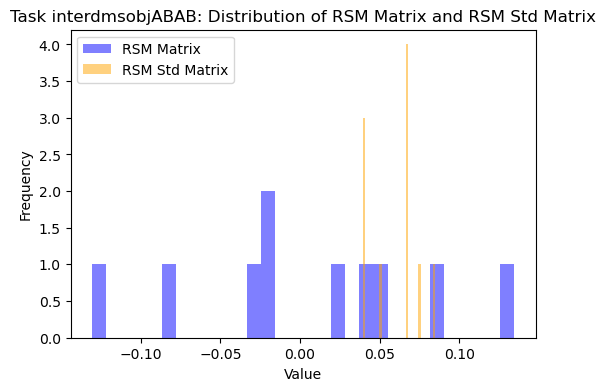

number of trials: 60


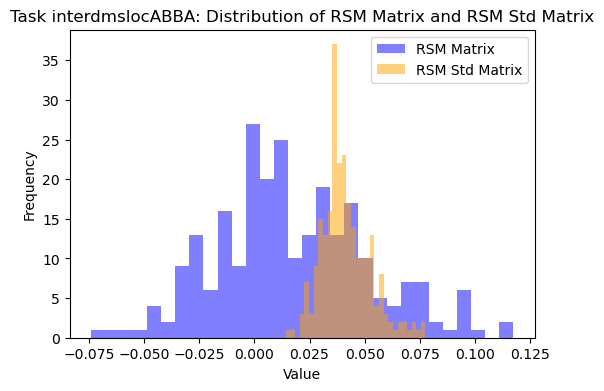

number of trials: 56


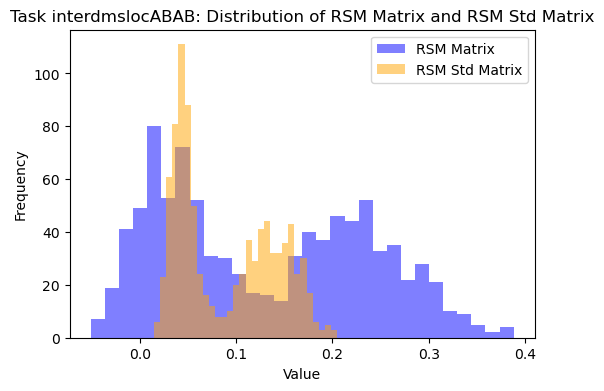

number of trials: 13


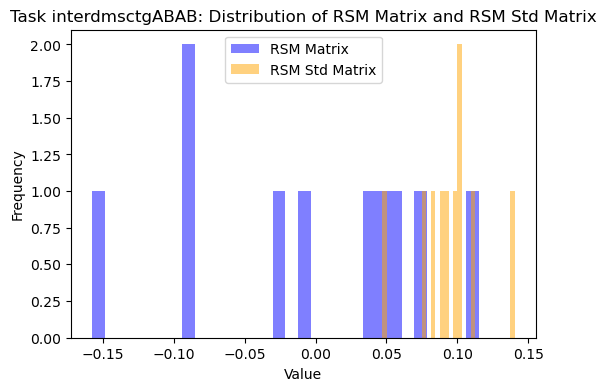

number of trials: 24


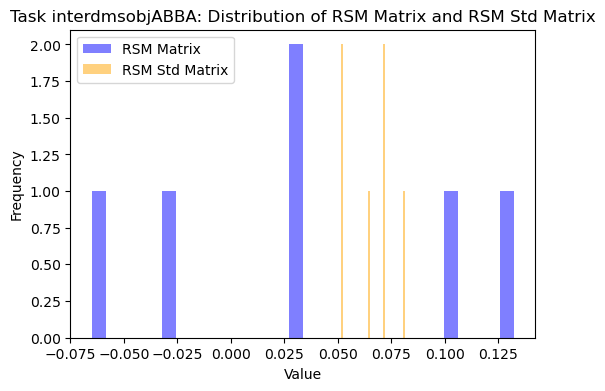

number of trials: 16


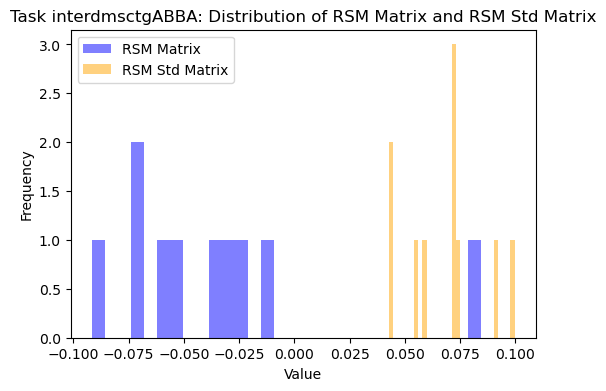

In [114]:
import matplotlib.pyplot as plt
region = "whole_brain"
metric = "cosine"
regionwise_task_betas = regionwise_beta(filtered_task_betas, mapped_atlas, region = region)
# Number of bootstraps
n_bootstraps = 10

for task in regionwise_task_betas.keys():
    if task == "1backctg" or task == "1backobj": continue
    curr_task_betas = regionwise_task_betas[task]
    rsm_matrix, rsm_std_matrix = within_task_within_subset_sessionwise_cosine_similarity(curr_task_betas, method = metric, n_bootstraps = n_bootstraps)

    rsm_matrix = rsm_matrix.reshape(-1)
    rsm_std_matrix = rsm_std_matrix.reshape(-1)
    
    # Plotting the distributions
    plt.figure(figsize=(6, 4))
    
    # Plot the distribution of rsm_matrix
    plt.hist(rsm_matrix, bins=30, alpha=0.5, label='RSM Matrix', color='blue')
    
    # Plot the distribution of rsm_std_matrix
    plt.hist(rsm_std_matrix, bins=30, alpha=0.5, label='RSM Std Matrix', color='orange')
    
    # Adding title and labels
    plt.title('Task %s: Distribution of RSM Matrix and RSM Std Matrix' % task)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    # Adding a legend
    plt.legend()
    
    # Show the plot
    plt.show()
    


## sanity check 2: for whole-brain/V1, for all task (except the one only has two sessions), calculate RSM matrix for N-1 session

In [115]:
def make_rsa_figures(rsm_matrix, rsm_std_matrix, all_tasks, metric = "Cosine Similarity", region = "V1"):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Adjusted for two plots side by side within a 6x6 space
    
    vmax = np.max([np.max(rsm_matrix), np.max(rsm_std_matrix)])
    vmin = np.min([np.min(rsm_matrix), np.min(rsm_std_matrix)])
    
    
    # Plot the RSM matrix
    im1 = axs[0].imshow(rsm_matrix, vmax=vmax, vmin=vmin, cmap='viridis')
    axs[0].set_title('Representational Similarity Matrix (RSM)')
    axs[0].set_xlabel('Task')
    axs[0].set_ylabel('Task')
    axs[0].set_xticks(range(len(all_tasks)))  # Set positions of x-ticks
    axs[0].set_xticklabels(all_tasks, rotation=45, ha="right")  # Set labels with a 45-degree tilt
    axs[0].set_yticks(range(len(all_tasks)))  # Set positions of x-ticks
    axs[0].set_yticklabels(all_tasks, rotation=45, ha="right")  # Set labels with a 45-degree tilt
    
    
    cbar1 = fig.colorbar(im1, ax=axs[0], shrink=0.8)
    cbar1.set_label(metric)
    
    # Plot the RSM standard deviation matrix
    im2 = axs[1].imshow(rsm_std_matrix, vmax=vmax, vmin=vmin, cmap='viridis')
    axs[1].set_title('RSM Standard Deviation')
    axs[1].set_xlabel('Task')
    axs[1].set_ylabel('Task')
    axs[1].set_xticks(range(len(all_tasks)))  # Set positions of x-ticks
    axs[1].set_xticklabels(all_tasks, rotation=45, ha="right")  # Set labels with a 45-degree tilt
    axs[1].set_yticks(range(len(all_tasks)))  # Set positions of x-ticks
    axs[1].set_yticklabels(all_tasks, rotation=45, ha="right")  # Set labels with a 45-degree tilt
    
    
    cbar2 = fig.colorbar(im2, ax=axs[1], shrink=0.8)
    cbar2.set_label('Standard Deviation')
    
    # Set the general title as the task name
    fig.suptitle("metric %s, region %s" % (metric, region), fontsize=16)
    
    # Adjust layout to fit the figure size
    plt.tight_layout()
    plt.show()
    


In [116]:
import numpy as np

def bootstrap_rsa(data_1, data_2, n_bootstraps=10, sample_fraction=0.8, method = "cosine", is_same_data = False):
    """Perform the bootstrap sampling for data_1 and data_2
        calculate the average vectror and RSA calculation across bootstraps."""
    rsa = []
    for _ in range(n_bootstraps):
        if not is_same_data:
            # Randomly sample sample_fraction of the trials
            sample_size = int(sample_fraction * len(data_1))
            sampled_indices_1 = random.sample(range(data_1.shape[0]), sample_size)
            sampled_data_1 = data_1[sampled_indices_1]
    
            
            sample_size = int(sample_fraction * len(data_2))
            sampled_indices_2 = random.sample(range(data_2.shape[0]), sample_size)
            sampled_data_2 = data_2[sampled_indices_2]
        else:
            # Randomly sample sample_fraction of the trials
            sample_size = int(sample_fraction * len(data_1))
            
            # Sample indices for data_1
            sampled_indices_1 = random.sample(range(data_1.shape[0]), sample_size)
            sampled_data_1 = data_1[sampled_indices_1]
            
            # Define the remaining indices that are not in sampled_indices_1
            remaining_indices_2 = list(set(range(data_2.shape[0])) - set(sampled_indices_1))
            
            # Ensure that the sample size does not exceed the number of remaining indices
            sample_size_2 = min(sample_size, len(remaining_indices_2))
            
            # Sample indices for data_2 from the remaining indices
            sampled_indices_2 = random.sample(remaining_indices_2, sample_size_2)
            sampled_data_2 = data_2[sampled_indices_2]
        
        # print("the number of same sampled indices:", len(list(set(sampled_indices_1) & set(sampled_indices_2)))/sample_size)


        mean_sampled_data_1 = np.mean(sampled_data_1, axis = 0)
        mean_sampled_data_2 = np.mean(sampled_data_2, axis = 0)
        if method == "cosine":
            # Compute RSM (cosine similarity in this case)
            rsm_value = cosine_similarity_vector(mean_sampled_data_1, mean_sampled_data_2)
        elif method == "pearson":
            rsm_value = pearson_correlation_vector(mean_sampled_data_1, mean_sampled_data_2)
        rsa.append(rsm_value)
       
    
    # Calculate the average and standard deviation of the RSA value
    rsa_mean = np.mean(rsa)
    rsa_std = np.std(rsa)
    
    return rsa_mean, rsa_std


excluded session: 0
T-test: t_stat=10.870927060114854, p_value=4.5354360386927555e-06
significantly higher
Wilcoxon test: stat=0.0, p_value=0.00390625


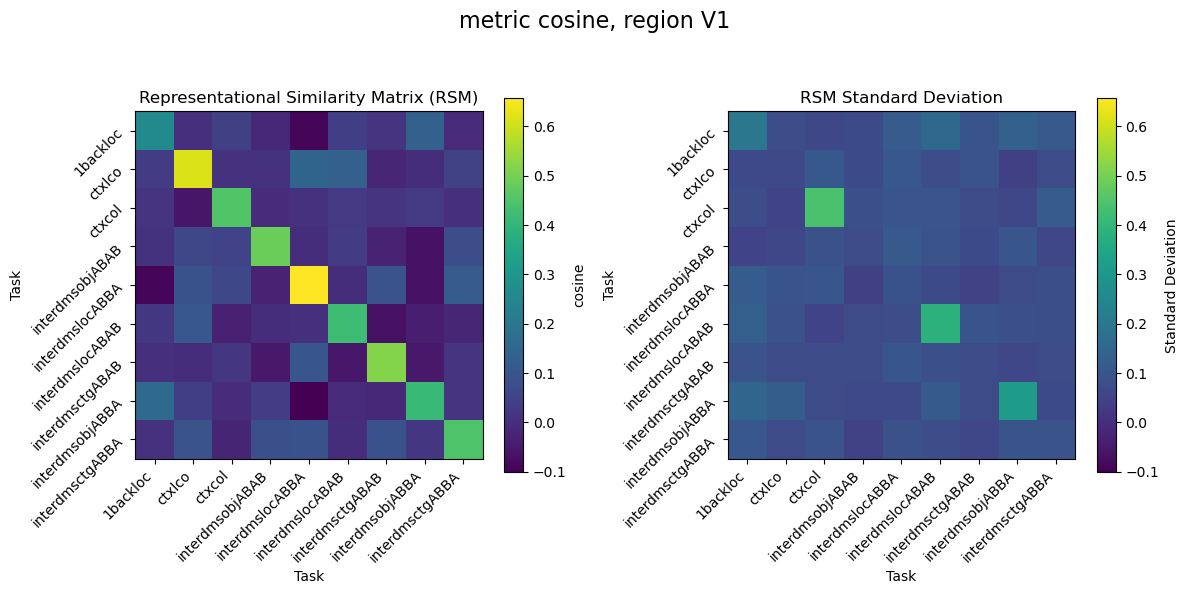

excluded session: 1
T-test: t_stat=13.868722109877222, p_value=7.066301768252299e-07
significantly higher
Wilcoxon test: stat=0.0, p_value=0.00390625


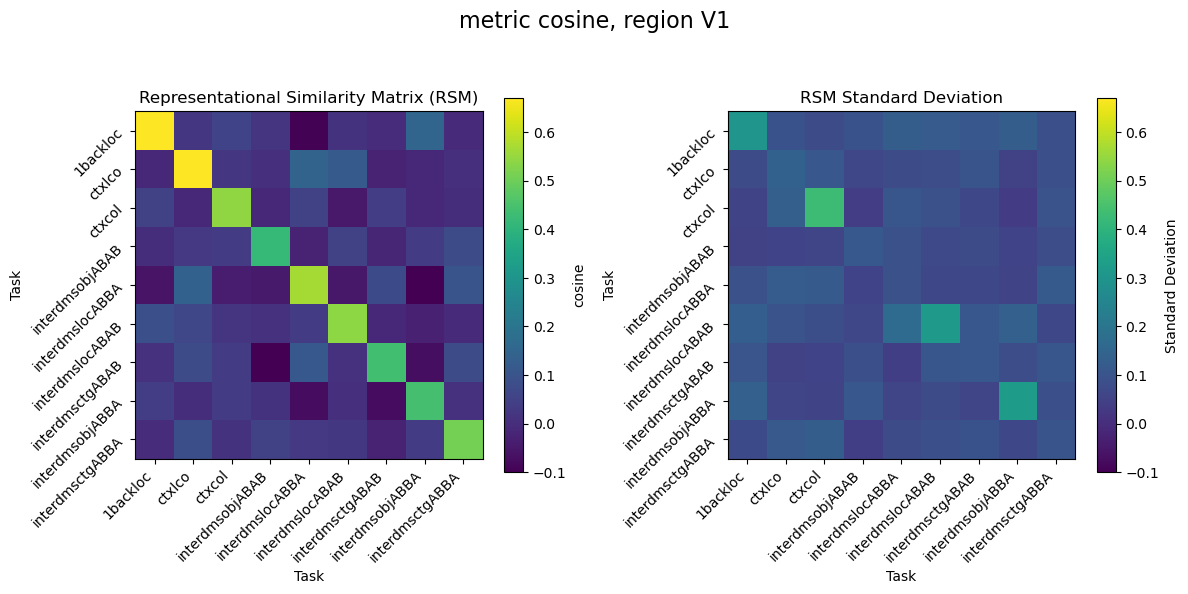

excluded session: 2
T-test: t_stat=9.155960420275806, p_value=1.6329526960059724e-05
significantly higher
Wilcoxon test: stat=0.0, p_value=0.00390625


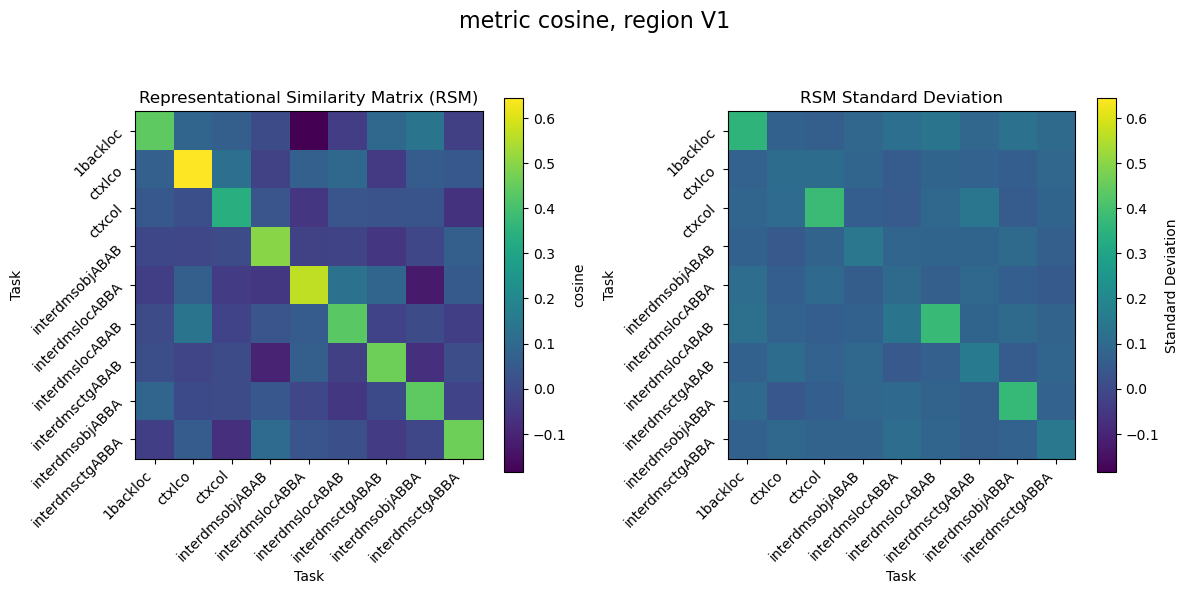

excluded session: 3
T-test: t_stat=7.4129887137149, p_value=7.525488515335974e-05
significantly higher
Wilcoxon test: stat=0.0, p_value=0.00390625


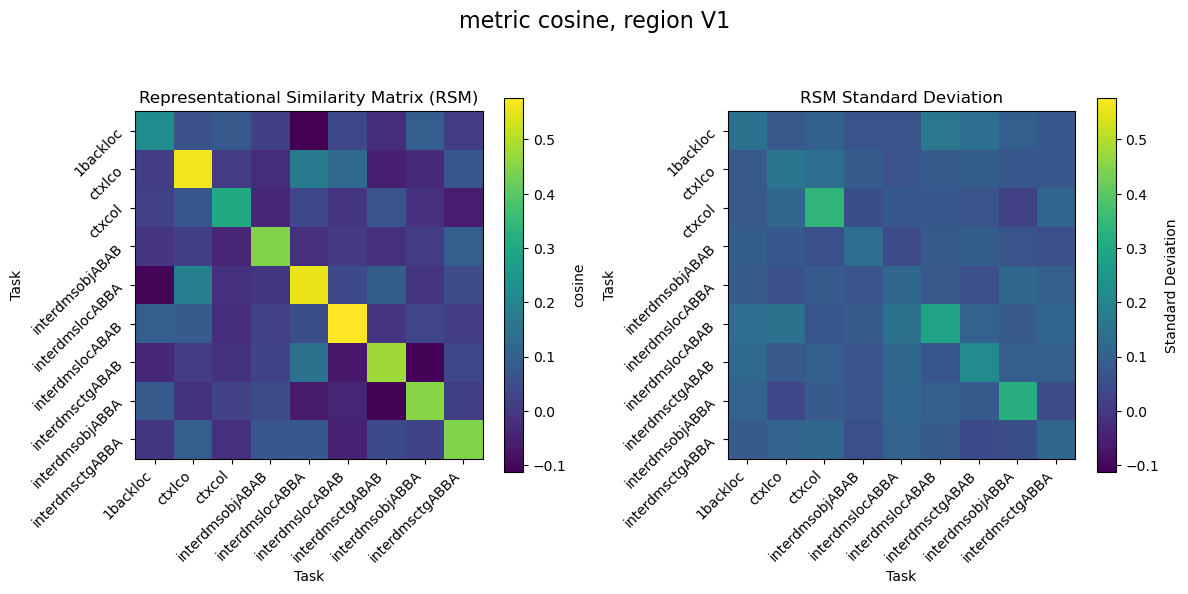

excluded session: 4
T-test: t_stat=10.88516186310771, p_value=4.490885390348355e-06
significantly higher
Wilcoxon test: stat=0.0, p_value=0.00390625


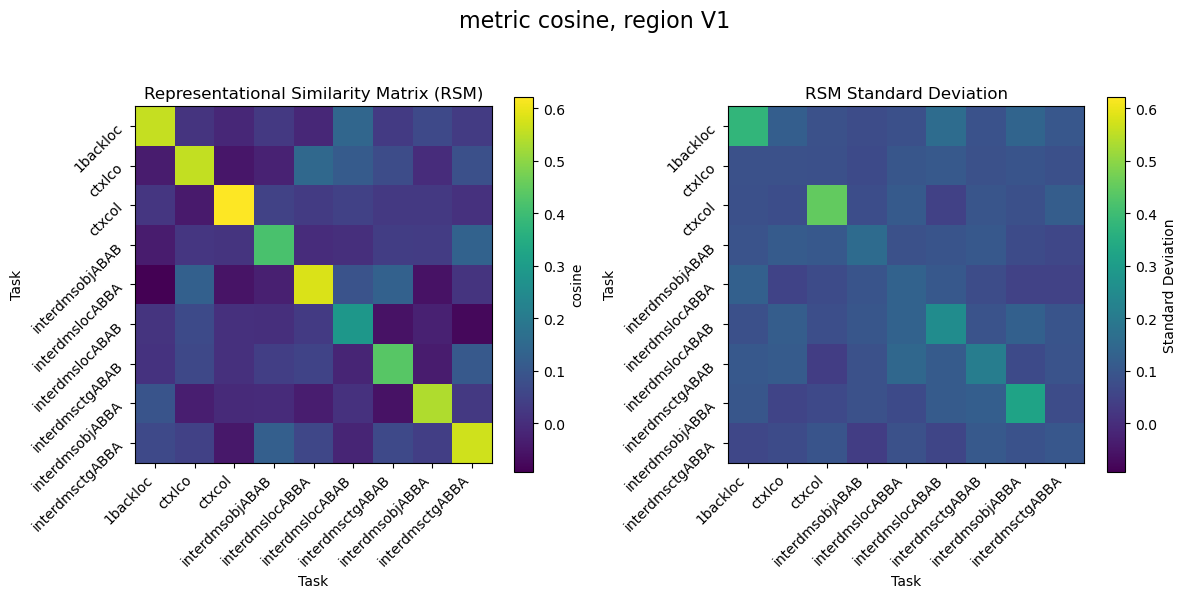

excluded session: 5
T-test: t_stat=8.374855137787753, p_value=3.1359858860335304e-05
significantly higher
Wilcoxon test: stat=0.0, p_value=0.00390625


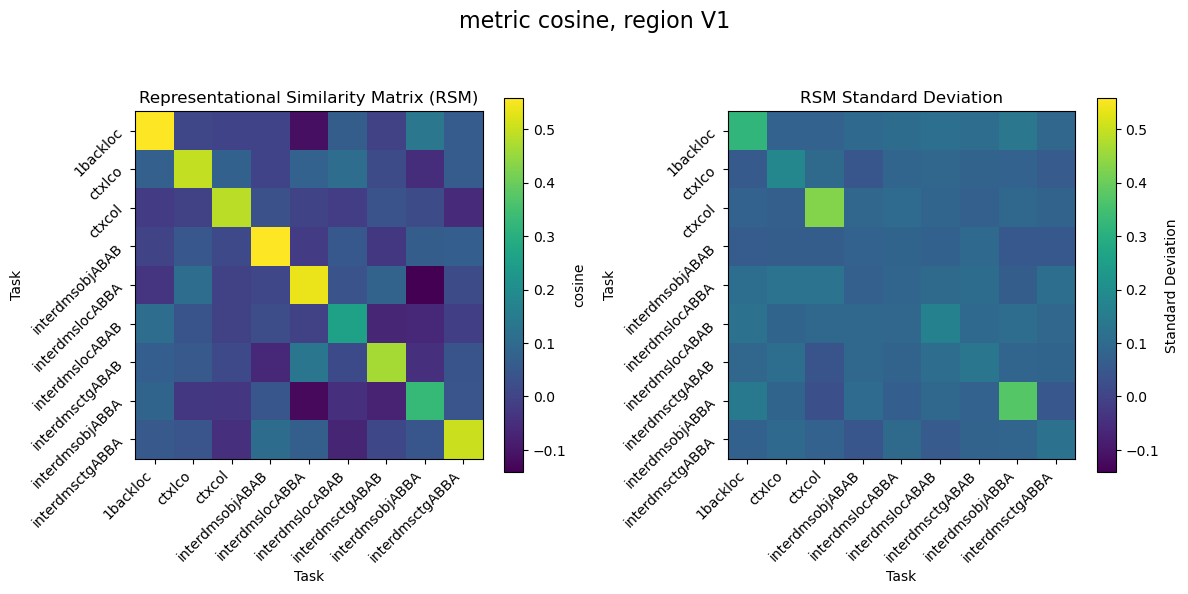

excluded session: 6
T-test: t_stat=5.500500458376198, p_value=0.0005734058405550831
significantly higher
Wilcoxon test: stat=0.0, p_value=0.00390625


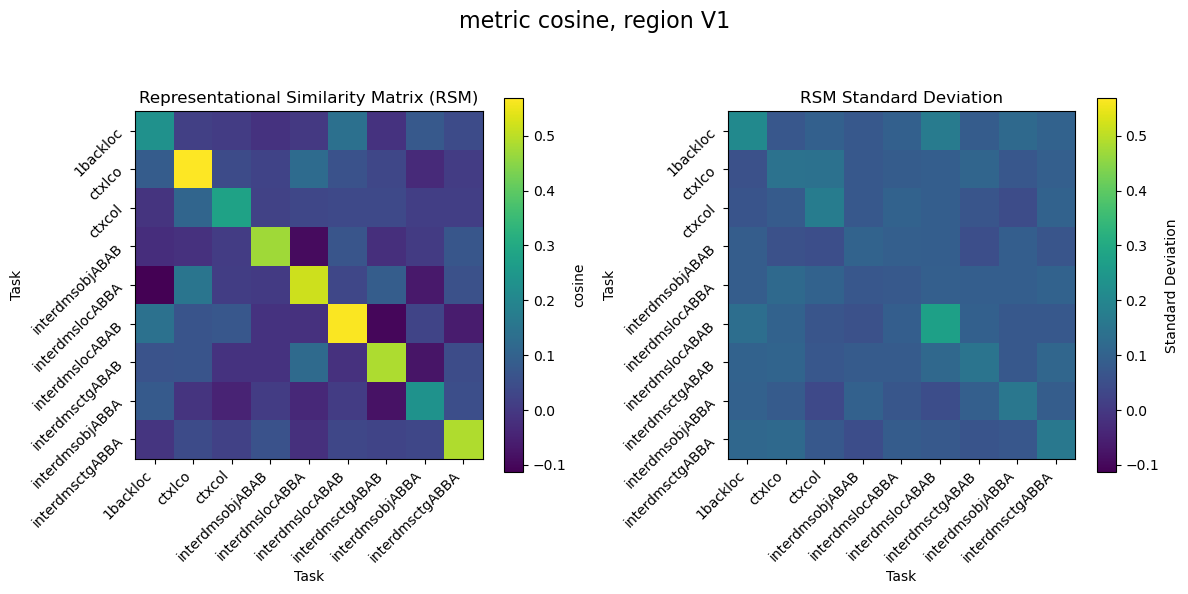

excluded session: 7
T-test: t_stat=9.1085069455697, p_value=1.6966914777681454e-05
significantly higher
Wilcoxon test: stat=0.0, p_value=0.00390625


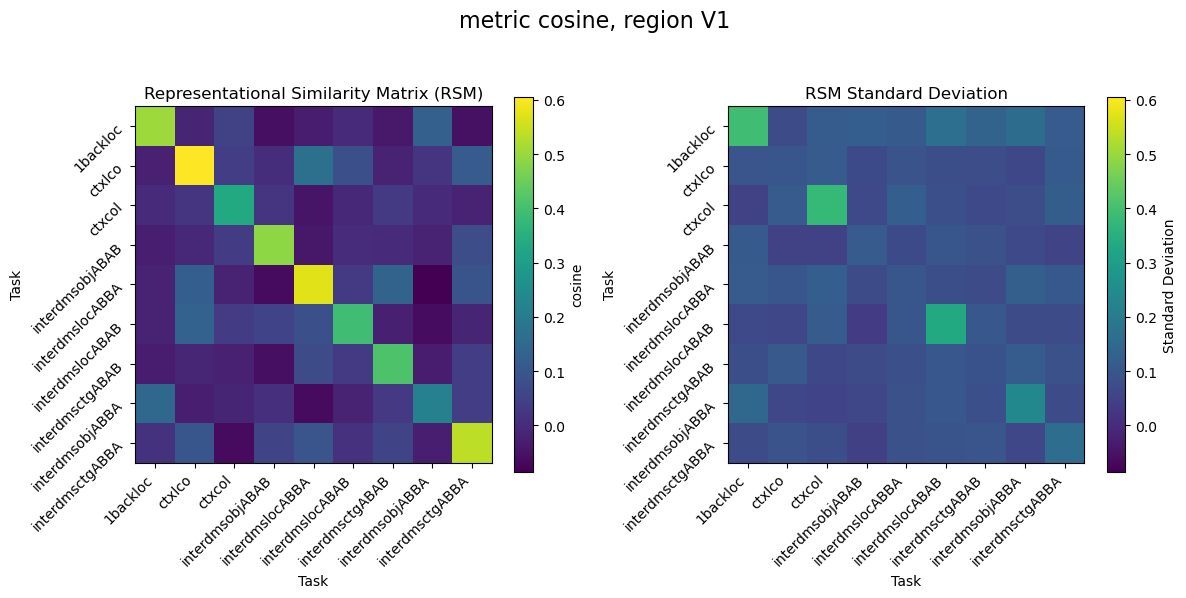

excluded session: 8
T-test: t_stat=15.362256405976048, p_value=3.202159896290851e-07
significantly higher
Wilcoxon test: stat=0.0, p_value=0.00390625


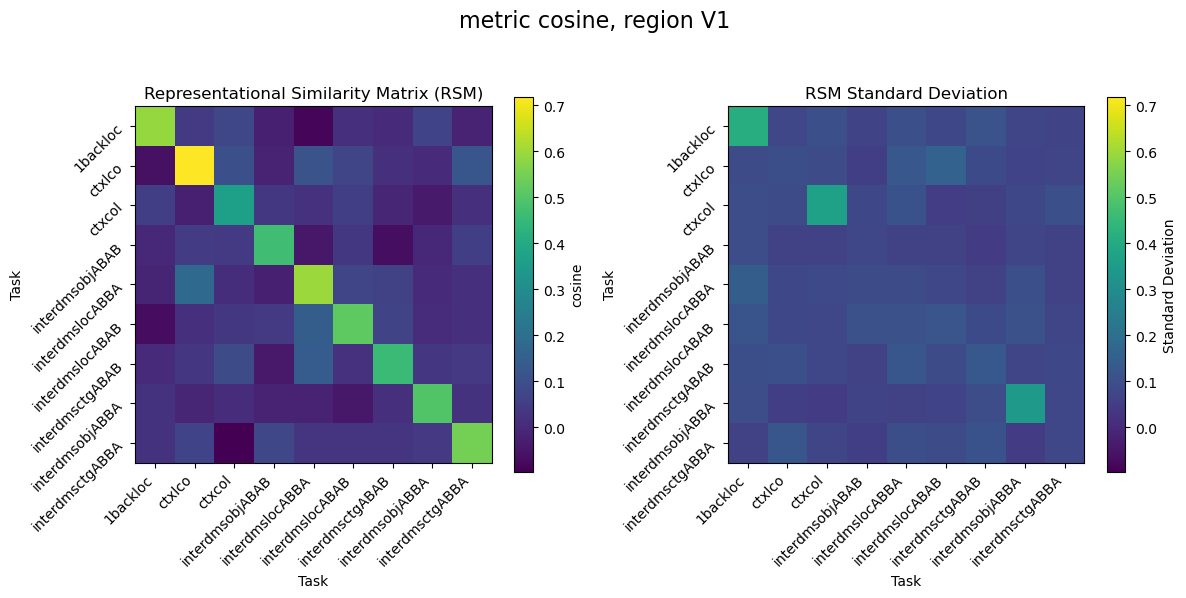

excluded session: 9
T-test: t_stat=7.428003137543492, p_value=7.418382879613783e-05
significantly higher
Wilcoxon test: stat=0.0, p_value=0.00390625


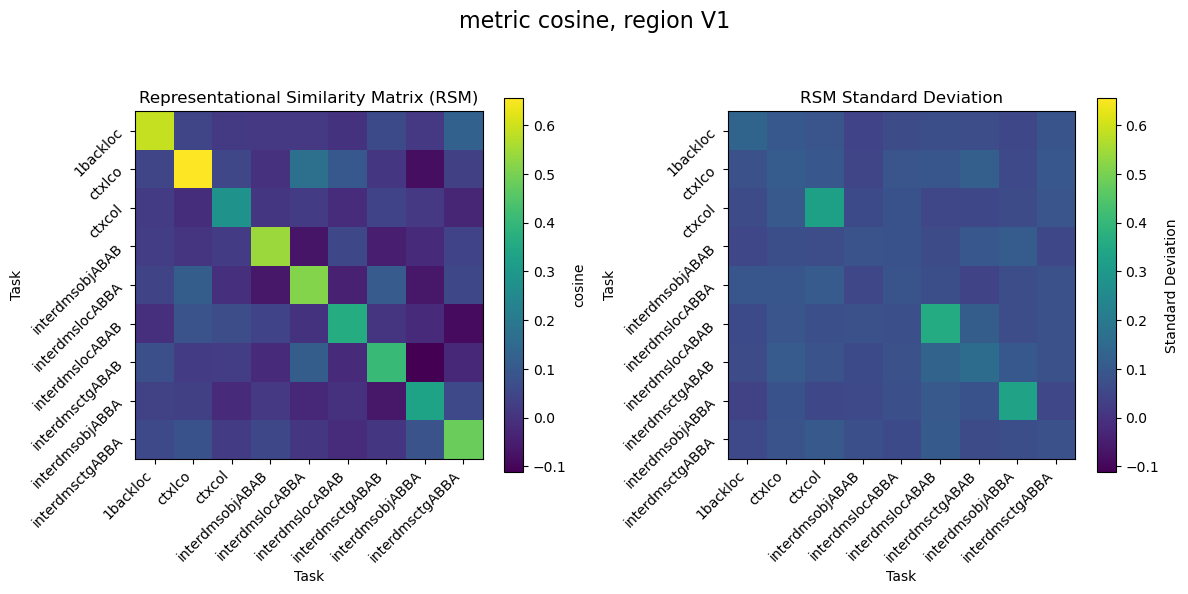

excluded session: 10
T-test: t_stat=6.6515574581752865, p_value=0.0001605480420382028
significantly higher
Wilcoxon test: stat=0.0, p_value=0.00390625


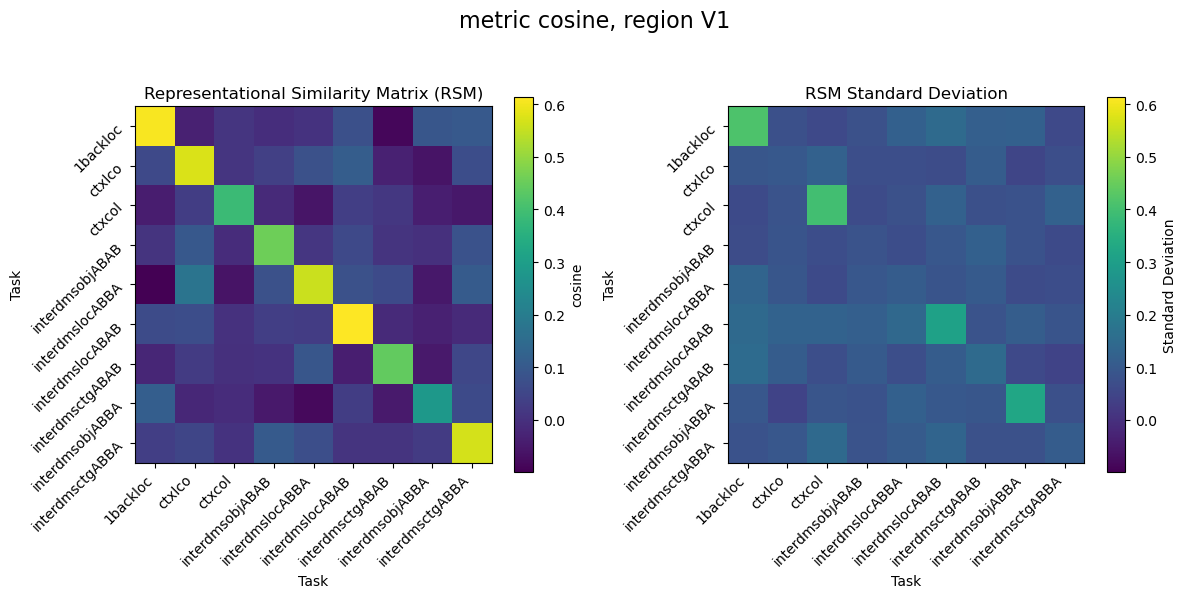

excluded session: 11
T-test: t_stat=10.58529901471406, p_value=5.542530495051077e-06
significantly higher
Wilcoxon test: stat=0.0, p_value=0.00390625


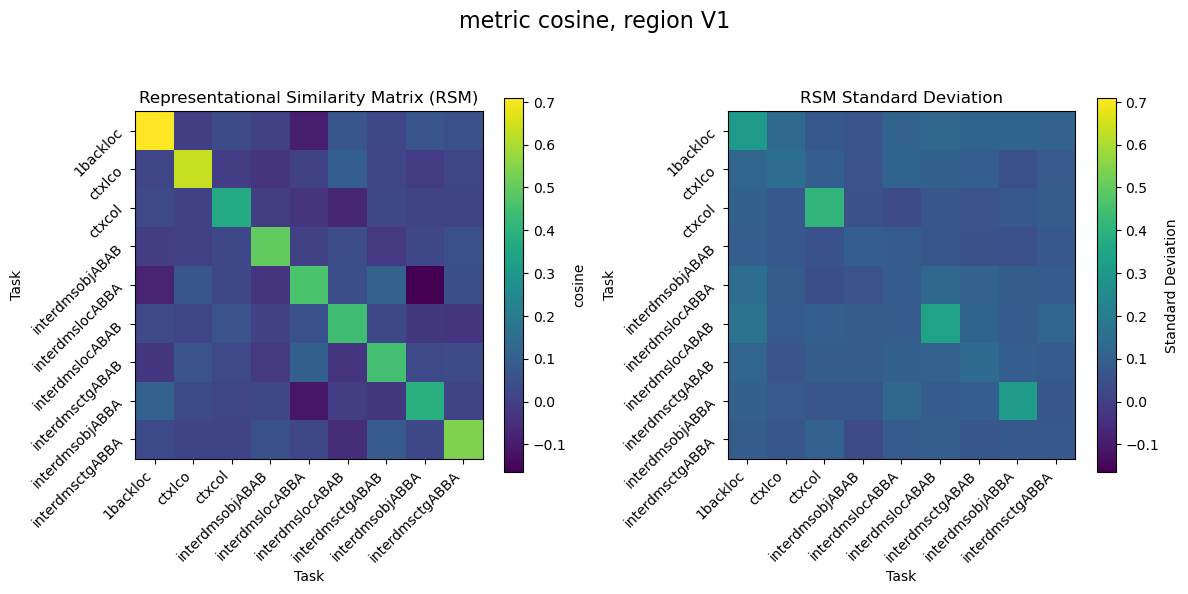

excluded session: 12
T-test: t_stat=11.18362446652079, p_value=3.6607692478593413e-06
significantly higher
Wilcoxon test: stat=0.0, p_value=0.00390625


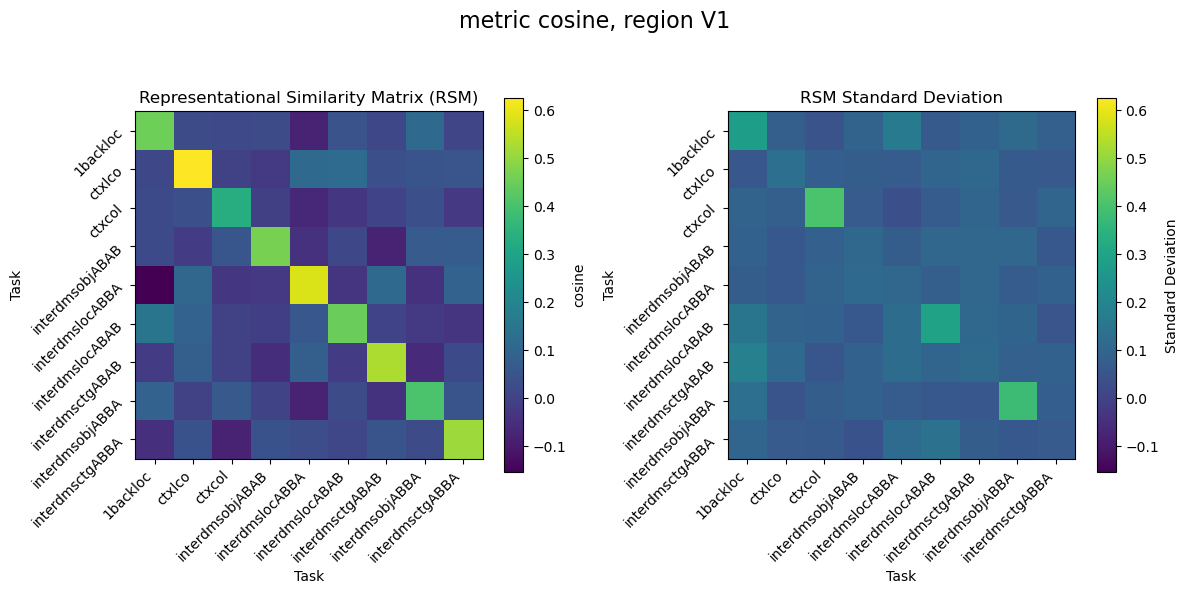

excluded session: 13
T-test: t_stat=10.147785633685848, p_value=7.606781144726828e-06
significantly higher
Wilcoxon test: stat=0.0, p_value=0.00390625


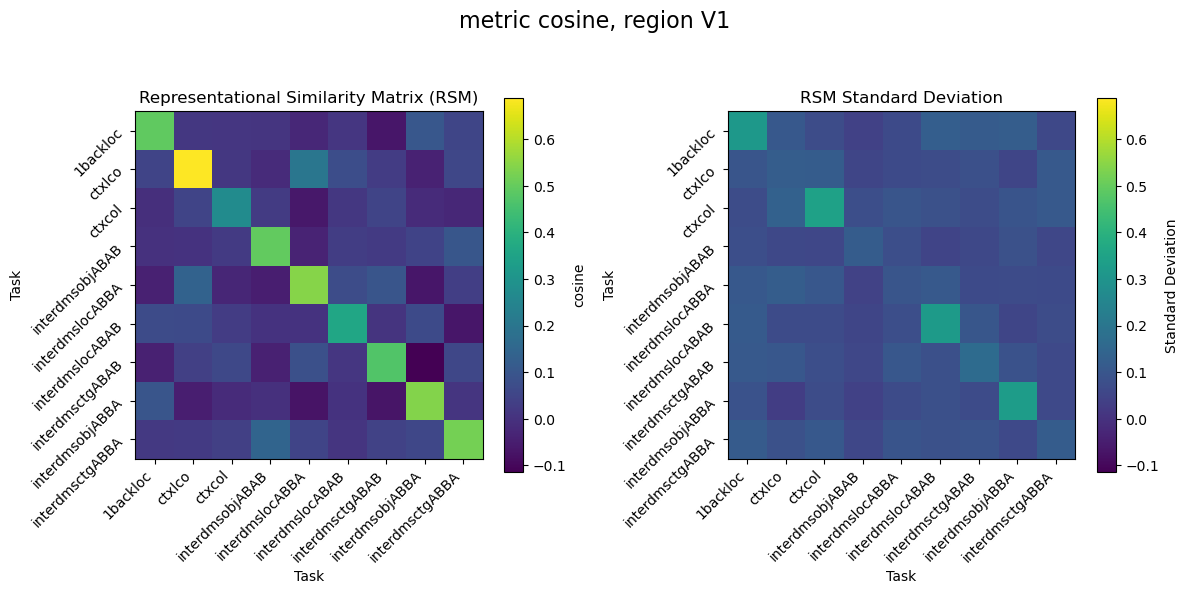

excluded session: 14
T-test: t_stat=7.271575037746957, p_value=8.622864285415362e-05
significantly higher
Wilcoxon test: stat=0.0, p_value=0.00390625


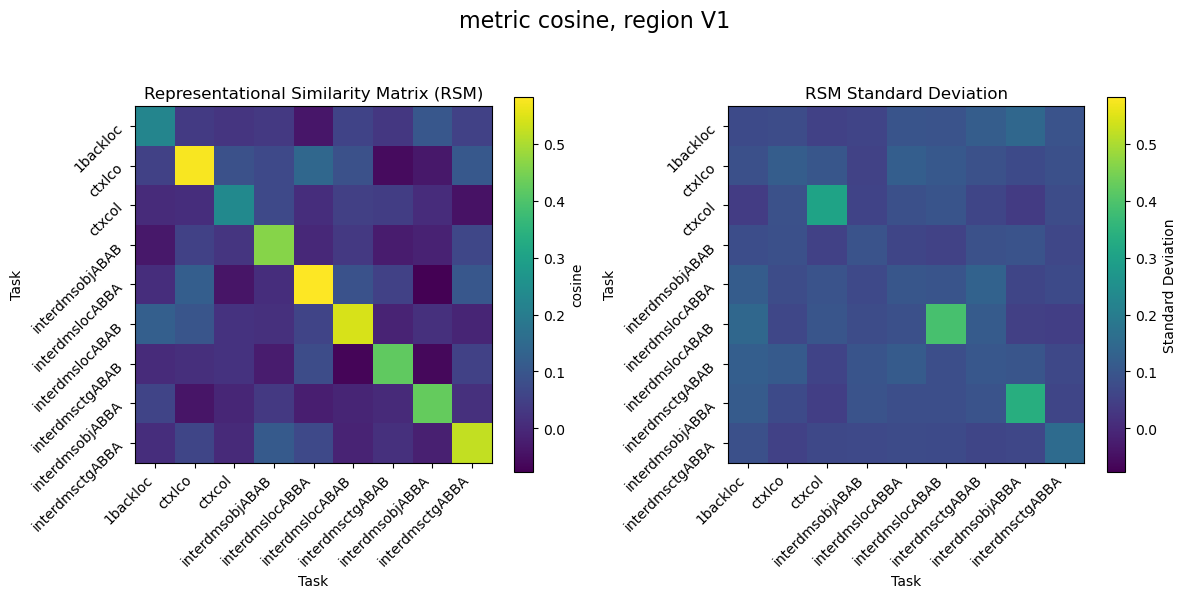

excluded session: 15
T-test: t_stat=15.151118575402919, p_value=3.5652230703096167e-07
significantly higher
Wilcoxon test: stat=0.0, p_value=0.00390625


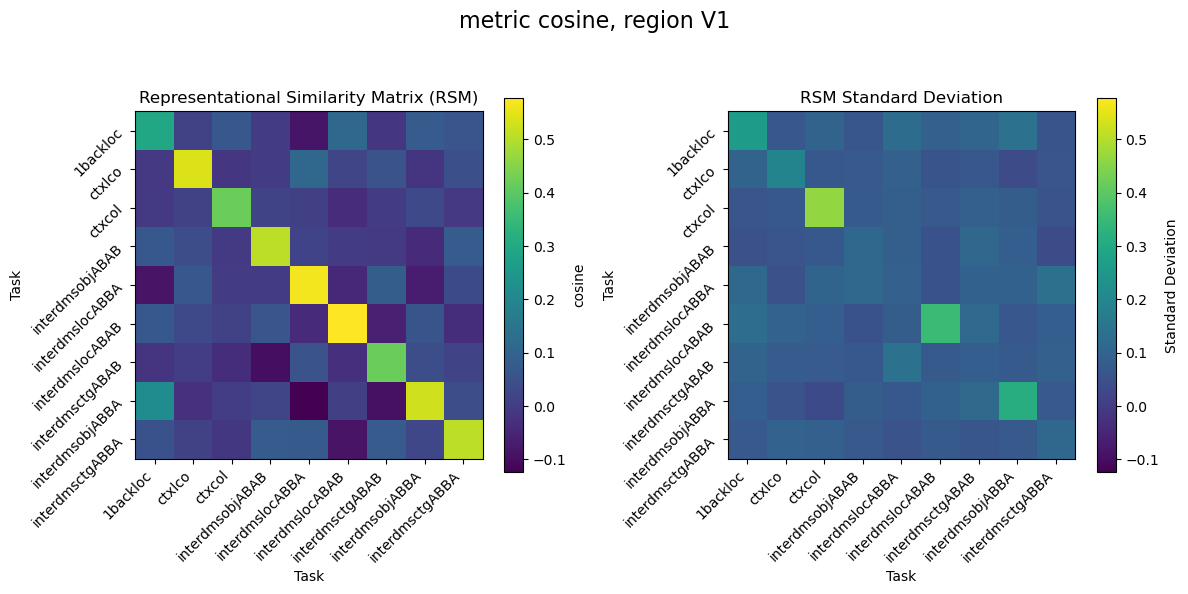

In [120]:
from scipy.stats import ttest_rel, wilcoxon
region = "V1"
metric = "cosine" # ('correlation', 'cosine', 'euclidean')
regionwise_task_betas = regionwise_beta(filtered_task_betas, mapped_atlas, region = region)
# Number of bootstraps
n_bootstraps = 10
n_session = 16
sample_fraction = 0.5

all_rsms = []

for except_ses in range(n_session):
    print("excluded session:", except_ses)
    
    inclu_ses = set(range(1, n_session + 1)) - set([except_ses])
    
    rsm_mean = np.zeros((len(regionwise_task_betas.keys())-2, len(regionwise_task_betas.keys())-2))
    rsm_std = np.zeros((len(regionwise_task_betas.keys())-2, len(regionwise_task_betas.keys())-2))
    tasks = []
    i = j = -1
    for task_a in regionwise_task_betas.keys():
        if task_a == "1backctg" or task_a == "1backobj": continue
        tasks.append(task_a)
        i += 1
        curr_task_betas = regionwise_task_betas[task_a]
        # Iterate through the selected sessions and get all trial data
        concatenated_data_a = []
        for ses in inclu_ses:
            for run in curr_task_betas["ses%d"%ses].keys():
                concatenated_data_a.append(curr_task_betas["ses%d"%ses][run].T)
        concatenated_data_a = np.concatenate(concatenated_data_a, axis = 0)
        j=-1
        for task_b in regionwise_task_betas.keys():
            if task_b == "1backctg" or task_b == "1backobj": continue
            
            j += 1
            curr_task_betas = regionwise_task_betas[task_b]
            concatenated_data_b = []
            for ses in inclu_ses:
                for run in curr_task_betas["ses%d"%ses].keys():
                    concatenated_data_b.append(curr_task_betas["ses%d"%ses][run].T)
            concatenated_data_b = np.concatenate(concatenated_data_b, axis = 0)

            # randomly sampled subset of trials from contactenated_data_a and concatenated_data_b
            # calcualte similarity between the averaged trial_activation => mean an std

            if task_a == task_b:
                is_same_data = True
            else:
                is_same_data = False
            curr_rsa_mean, curr_rsa_std = bootstrap_rsa(concatenated_data_a, concatenated_data_b,
                                                        n_bootstraps=n_bootstraps, sample_fraction=sample_fraction, 
                                                        method = metric, is_same_data = False)
            rsm_mean[i,j] = curr_rsa_mean
            rsm_std[i,j] = curr_rsa_std

    # test if ondiagonal values are significantly higher than off-diagonal values
    # Step 1: Separate on-diagonal and off-diagonal values
    on_diagonal = np.diag(rsm_mean)
    off_diagonal = rsm_mean[np.triu_indices(len(rsm_mean), k=1)] + rsm_mean[np.tril_indices(len(rsm_mean), k=-1)]
    
    # Step 2: Perform a paired t-test
    t_stat, p_value = ttest_rel(on_diagonal, off_diagonal[:len(on_diagonal)])
    
    print(f"T-test: t_stat={t_stat}, p_value={p_value}")
    if p_value < 0.005:
        print("significantly higher")
    # Alternatively, perform a Wilcoxon signed-rank test if the data is not normally distributed
    wilcoxon_stat, wilcoxon_p_value = wilcoxon(on_diagonal, off_diagonal[:len(on_diagonal)])
    print(f"Wilcoxon test: stat={wilcoxon_stat}, p_value={wilcoxon_p_value}")
    
    all_rsms.append(rsm_mean)
    make_rsa_figures(rsm_mean, rsm_std , all_tasks = tasks, metric = metric, region = region)
    
    
    

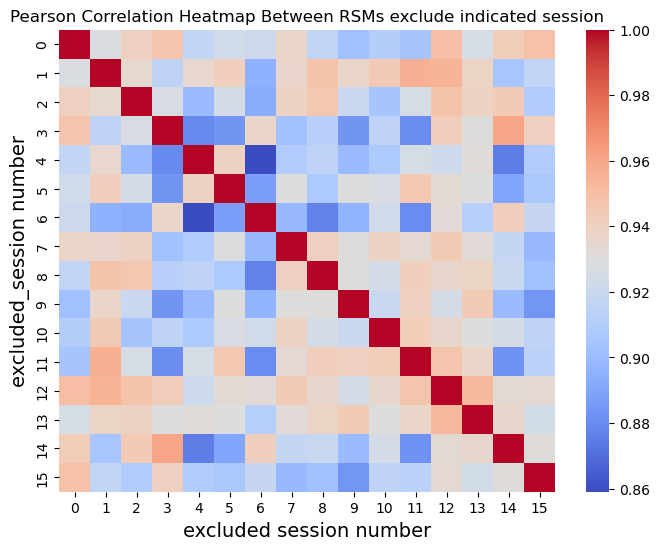

In [121]:
# calculate the pearson correlation between pairs of rsa matrices (each exclude one session)
from scipy.stats import pearsonr

def flatten_matrix(matrix):
    return matrix.flatten()

def calculate_pearson_matrix(matrices):
    num_matrices = len(matrices)
    correlation_matrix = np.zeros((num_matrices, num_matrices))

    for i in range(num_matrices):
        for j in range(i, num_matrices):
            # Flatten matrices and calculate Pearson correlation
            vec1 = flatten_matrix(matrices[i])
            vec2 = flatten_matrix(matrices[j])
            correlation, _ = pearsonr(vec1, vec2)
            
            # Fill the matrix
            correlation_matrix[i, j] = correlation
            correlation_matrix[j, i] = correlation
    
    return correlation_matrix



correlation_matrix = calculate_pearson_matrix(all_rsms)

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", vmin=np.min(correlation_matrix), vmax=np.max(correlation_matrix))
plt.title('Pearson Correlation Heatmap Between RSMs exclude indicated session')
plt.xlabel("excluded session number", fontsize = 14)
plt.ylabel("excluded_session number", fontsize = 14)
plt.show()


included session: 1
T-test: t_stat=-0.08391311282887286, p_value=0.9351873214160403
Wilcoxon test: stat=18.0, p_value=0.65234375


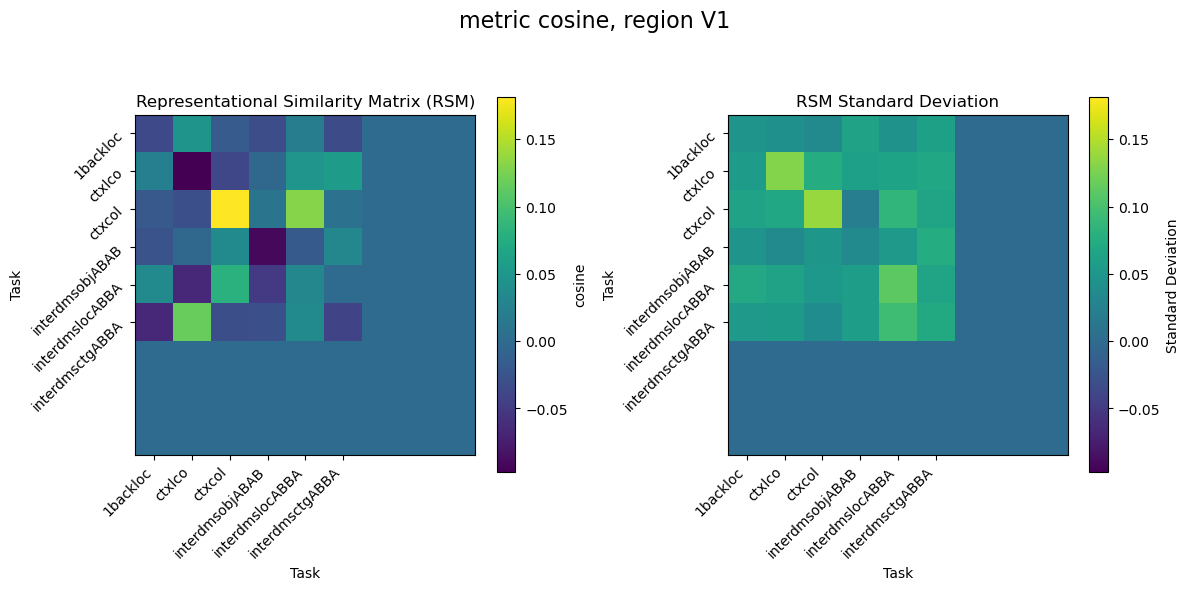

In [101]:
# within the same session, split the trials into half and half, calulate the cosine similarity between the same tasks
from scipy.stats import ttest_rel, wilcoxon
region = "V1"
metric = "cosine" # ('correlation', 'cosine', 'euclidean')
regionwise_task_betas = regionwise_beta(filtered_task_betas,  mapped_atlas, region = region)
# Number of bootstraps
n_bootstraps = 10
n_session = 16
sample_fraction = 0.5

all_rsms = []

for except_ses in range(1, n_session + 1):
    print("included session:", except_ses)
    
    inclu_ses = [except_ses]
    
    rsm_mean = np.zeros((len(regionwise_task_betas.keys())-2, len(regionwise_task_betas.keys())-2))
    rsm_std = np.zeros((len(regionwise_task_betas.keys())-2, len(regionwise_task_betas.keys())-2))
    tasks = []
    i = j = -1
    for task_a in regionwise_task_betas.keys():
        if task_a == "1backctg" or task_a == "1backobj": continue
        
        
        curr_task_betas = regionwise_task_betas[task_a]
        # Iterate through the selected sessions and get all trial data
        concatenated_data_a = []
        for ses in inclu_ses:
            for run in curr_task_betas["ses%d"%ses].keys():
                concatenated_data_a.append(curr_task_betas["ses%d"%ses][run].T)
        if len(concatenated_data_a) == 0:
            continue
        concatenated_data_a = np.concatenate(concatenated_data_a, axis = 0)
        if len(concatenated_data_a) < 5:
            continue
        tasks.append(task_a)
        i += 1
        j=-1
        for task_b in regionwise_task_betas.keys():
            if task_b == "1backctg" or task_b == "1backobj": continue
            
            
            curr_task_betas = regionwise_task_betas[task_b]
            concatenated_data_b = []
            for ses in inclu_ses:
                for run in curr_task_betas["ses%d"%ses].keys():
                    concatenated_data_b.append(curr_task_betas["ses%d"%ses][run].T)
            if len(concatenated_data_b) == 0:
                continue
            concatenated_data_b = np.concatenate(concatenated_data_b, axis = 0)

            if len(concatenated_data_b) < 5:
                continue
            j += 1
            # randomly sampled subset of trials from contactenated_data_a and concatenated_data_b
            # calcualte similarity between the averaged trial_activation => mean an std

            if task_a == task_b:
                is_same_data = True
            else:
                is_same_data = False
            curr_rsa_mean, curr_rsa_std = bootstrap_rsa(concatenated_data_a, concatenated_data_b, n_bootstraps=n_bootstraps, sample_fraction=sample_fraction, method = metric, is_same_data = is_same_data)
            rsm_mean[i,j] = curr_rsa_mean
            rsm_std[i,j] = curr_rsa_std

    # test if ondiagonal values are significantly higher than off-diagonal values
    # Step 1: Separate on-diagonal and off-diagonal values
    on_diagonal = np.diag(rsm_mean)
    off_diagonal = rsm_mean[np.triu_indices(len(rsm_mean), k=1)] + rsm_mean[np.tril_indices(len(rsm_mean), k=-1)]
    
    # Step 2: Perform a paired t-test
    t_stat, p_value = ttest_rel(on_diagonal, off_diagonal[:len(on_diagonal)])
    
    print(f"T-test: t_stat={t_stat}, p_value={p_value}")
    if p_value < 0.005:
        print("significantly higher")
    # Alternatively, perform a Wilcoxon signed-rank test if the data is not normally distributed
    wilcoxon_stat, wilcoxon_p_value = wilcoxon(on_diagonal, off_diagonal[:len(on_diagonal)])
    print(f"Wilcoxon test: stat={wilcoxon_stat}, p_value={wilcoxon_p_value}")
    
    all_rsms.append(rsm_mean)
    make_rsa_figures(rsm_mean, rsm_std , all_tasks = tasks, metric = metric, region = region)
    
    break
    

## sanity check 3: for whole-brain/V1, for all task, calculate RSM matrix for data from subset of sessions

In [ ]:
import random
import matplotlib.pyplot as plt
region = "V1"
metric = "cosine"
regionwise_task_betas = regionwise_beta(filtered_task_betas, mapped_atlas, region = region)
all_tasks = []


# for each task, randomly half of the trials, obtain the trial data, bootstrap do the analysis
task_trials_data_sample1 = []
task_trials_data_sample2 = []
for i in range(2):
    for task in regionwise_task_betas.keys():
        if i == 0: all_tasks.append(task)
        curr_task_trials = 0
        curr_task_trials_data = []
        target_task_trials = int(n_trials_per_task[task]/2)
        sess_keys = list(regionwise_task_betas[task].keys())
    
        # Randomly shuffle the list of keys
        random.shuffle(sess_keys)
        for sess in sess_keys:
            if curr_task_trials >= target_task_trials:
                # obtained sufficient of trials
                break
            sess_trials = []
            for run in regionwise_task_betas[task][sess].keys():
                sess_trials.append(regionwise_task_betas[task][sess][run])
                
            if len(sess_trials) != 0: # when the task exist in that session
                sess_trials = np.concatenate(sess_trials, axis=1).T # n_trials * n_pixels
                
                # Number of trials to sample
                n_samples = int(sess_trials.shape[0] * sample_fraction)
                curr_task_trials += n_samples
                
                # Randomly select 80% of the data along the first dimension (trials)
                sampled_indices = np.random.choice(sess_trials.shape[0], n_samples, replace=True)
                sampled_data = sess_trials[sampled_indices, :]
                    
                curr_task_trials_data.append(sampled_data)
        curr_task_trials_data = np.concatenate(curr_task_trials_data, axis = 0)
        
        if i == 0:
            task_trials_data_sample1.append(curr_task_trials_data)
        elif i == 1:
            task_trials_data_sample2.append(curr_task_trials_data)
            
    


In [142]:
# Function to randomly sample and average a percentage of trials from an array
def random_sample_average(arr, percentage):
    num_samples = int(np.ceil(arr.shape[0] * percentage))
    sampled_indices = random.sample(range(arr.shape[0]), num_samples)
    sampled_trials = arr[sampled_indices, :]
    avg_vector = np.mean(sampled_trials, axis=0)
    return avg_vector


# Function to calculate the RSM matrix
def calculate_rsm(arrays_1, arrays_2, percentage, num_bootstrap=10, method = "cosine"):
    num_arrays = len(arrays_1)
    
    # Initialize matrices to accumulate results
    rsm_matrices = np.zeros((num_bootstrap, num_arrays, num_arrays))
    
    for b in range(num_bootstrap):
        rsm_matrix = np.zeros((num_arrays, num_arrays))
        for i in range(num_arrays):
            for j in range(i, num_arrays):
                # Randomly sample and average a percentage of trials from each array
                avg_i = random_sample_average(arrays_1[i], percentage)
                avg_j = random_sample_average(arrays_2[j], percentage)

                if method == "cosine":
                    # Calculate cosine similarity
                    similarity = cosine_similarity_vector(avg_i, avg_j)
                elif method == "pearson":
                    similarity = pearson_correlation_vector(avg_i, avg_j)
                
                
                
                # Fill in the RSM matrix
                rsm_matrix[i, j] = similarity
                rsm_matrix[j, i] = similarity  # Since the matrix is symmetric

        # Store the result for this bootstrap iteration
        rsm_matrices[b] = rsm_matrix
    
    # Calculate the average RSM and standard deviation across bootstraps
    avg_rsm = np.mean(rsm_matrices, axis=0)
    std_rsm = np.std(rsm_matrices, axis=0)
    
    return avg_rsm, std_rsm


# Define the percentage of samples to draw from each array
percentage = 0.5  # 20% of the trials in each array

# Calculate the RSM matrix
rsm_matrix, rsm_std_matrix = calculate_rsm(task_trials_data_sample1, task_trials_data_sample2, percentage, method = metric)
    

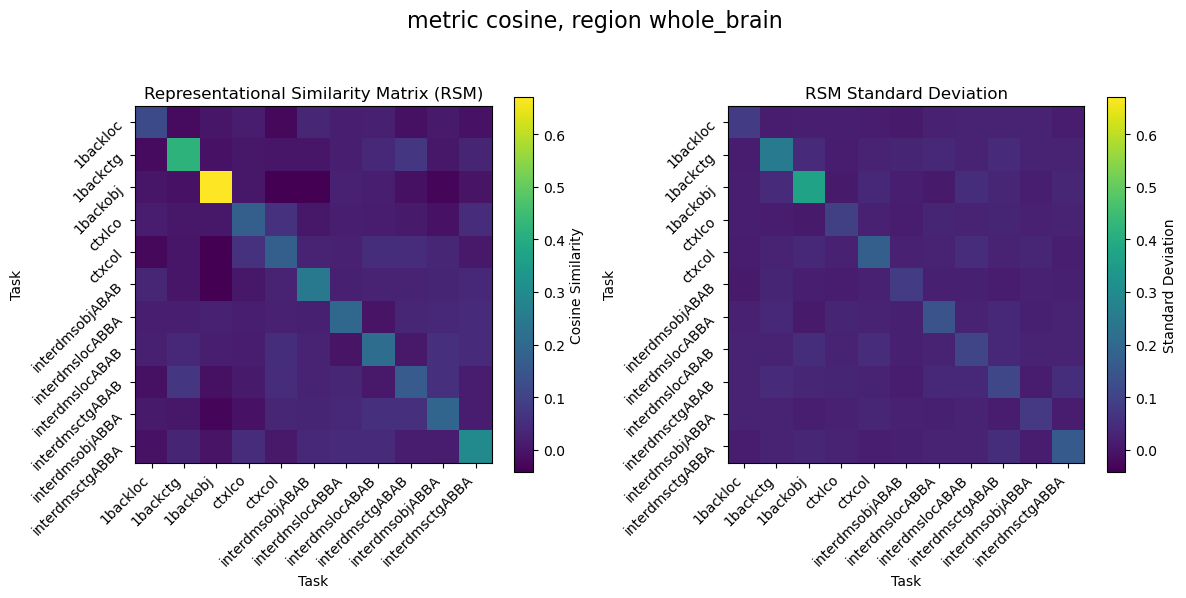

In [143]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Adjusted for two plots side by side within a 6x6 space

vmax = np.max([np.max(rsm_matrix), np.max(rsm_std_matrix)])
vmin = np.min([np.min(rsm_matrix), np.min(rsm_std_matrix)])


# Plot the RSM matrix
im1 = axs[0].imshow(rsm_matrix, vmax=vmax, vmin=vmin, cmap='viridis')
axs[0].set_title('Representational Similarity Matrix (RSM)')
axs[0].set_xlabel('Task')
axs[0].set_ylabel('Task')
axs[0].set_xticks(range(len(all_tasks)))  # Set positions of x-ticks
axs[0].set_xticklabels(all_tasks, rotation=45, ha="right")  # Set labels with a 45-degree tilt
axs[0].set_yticks(range(len(all_tasks)))  # Set positions of x-ticks
axs[0].set_yticklabels(all_tasks, rotation=45, ha="right")  # Set labels with a 45-degree tilt


cbar1 = fig.colorbar(im1, ax=axs[0], shrink=0.8)
cbar1.set_label('Cosine Similarity')

# Plot the RSM standard deviation matrix
im2 = axs[1].imshow(rsm_std_matrix, vmax=vmax, vmin=vmin, cmap='viridis')
axs[1].set_title('RSM Standard Deviation')
axs[1].set_xlabel('Task')
axs[1].set_ylabel('Task')
axs[1].set_xticks(range(len(all_tasks)))  # Set positions of x-ticks
axs[1].set_xticklabels(all_tasks, rotation=45, ha="right")  # Set labels with a 45-degree tilt
axs[1].set_yticks(range(len(all_tasks)))  # Set positions of x-ticks
axs[1].set_yticklabels(all_tasks, rotation=45, ha="right")  # Set labels with a 45-degree tilt


cbar2 = fig.colorbar(im2, ax=axs[1], shrink=0.8)
cbar2.set_label('Standard Deviation')

# Set the general title as the task name
fig.suptitle("metric %s, region %s" % (metric, region), fontsize=16)

# Adjust layout to fit the figure size
plt.tight_layout()
plt.show()



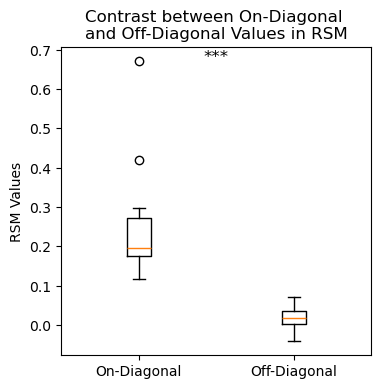

In [144]:
from scipy.stats import ttest_ind

# Extract on-diagonal and off-diagonal values
on_diagonal = np.diag(rsm_matrix)
off_diagonal = rsm_matrix[np.triu_indices_from(rsm_matrix, k=1)]

# Perform t-test
t_stat, p_value = ttest_ind(on_diagonal, off_diagonal)

# Create boxplot
plt.figure(figsize=(4, 4))
plt.boxplot([on_diagonal, off_diagonal], labels=['On-Diagonal', 'Off-Diagonal'])

# Add significance level indication
if p_value < 0.001:
    significance = "***"  # p < 0.001
elif p_value < 0.01:
    significance = "**"  # p < 0.01
elif p_value < 0.05:
    significance = "*"  # p < 0.05
else:
    significance = "n.s."  # Not significant

# Annotate the plot with the significance level
plt.text(1.5, max(max(on_diagonal), max(off_diagonal)), significance,
         horizontalalignment='center', fontsize=12)

# Add titles and labels
plt.title('Contrast between On-Diagonal \nand Off-Diagonal Values in RSM')
plt.ylabel('RSM Values')
plt.show()
